# Обучение сети c несколькими параметрами

Параметры обучения: Vgs, Vds, L, W, Temp

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

import time

In [2]:
tf.test.gpu_device_name()

''

In [ ]:
# !conda install -c conda-forge cudatoolkit=11.2 cudnn=8.1.0

In [ ]:
# !python -m pip install tensorflow

Загружаем свой датасет (простой)




In [ ]:
df = pd.read_csv('mosfet_simple.csv')

In [ ]:
# df = pd.read_csv('mosfet_complicated.csv')

In [ ]:
df.shape

(4563, 6)

In [ ]:
df.describe()

,Vds,Vgs,L,W,T,Id
count,4563.000000,4563.000000,4.563000e+03,4.563000e+03,4563.000000,4.563000e+03
mean,1.500000,1.500000,5.333333e-07,5.333333e-07,25.000000,1.432282e-04
std,0.935517,0.935517,3.399719e-07,3.399719e-07,20.414652,1.994167e-04
min,0.000000,0.000000,2.000000e-07,2.000000e-07,0.000000,-2.991882e-19
25%,0.750000,0.750000,2.000000e-07,2.000000e-07,0.000000,5.848275e-07
50%,1.500000,1.500000,4.000000e-07,4.000000e-07,25.000000,6.478563e-05
75%,2.250000,2.250000,1.000000e-06,1.000000e-06,50.000000,1.998776e-04
max,3.000000,3.000000,1.000000e-06,1.000000e-06,50.000000,1.132989e-03


Найдем уникальные значения

In [ ]:
df['Vds'].unique() 

array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
       2.75, 3.  ])

In [ ]:
df['L'].unique() 

array([2.e-07, 4.e-07, 1.e-06])

In [ ]:
df['W'].unique() 

array([2.e-07, 4.e-07, 1.e-06])

In [ ]:
df['T'].unique() 

array([ 0., 25., 50.])

In [ ]:
# # замена отрицательных значений на нули
df.loc[df["Id"] < 0, "Id"] = 0

In [ ]:
Id=df["Id"]
Vgs=df["Vgs"]
Vds=df["Vds"]
L=df["L"]
W=df["W"]
T=df["T"]


y=np.ravel(Id)
X=df.iloc[:,0:5]

In [ ]:
X.shape, y.shape

((4563, 5), (4563,))

In [ ]:
# Split train and test dataset
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Валидация

In [111]:
def print_loss(y_val, y_pred):
  loss = keras.losses.MSE(y_val, y_pred)
  mae = keras.losses.MAE(y_val, y_pred)
  print('MAX loss: ', np.max(loss.numpy()), 'mae: ', np.max(mae.numpy()))

  loss_mean = tf.reduce_mean(loss) # Рассчитать среднеквадратичную ошибку партии
  mae_mean = tf.reduce_mean(mae)
  print('MEAN loss: ', loss_mean.numpy(), 'mae: ', mae_mean.numpy())

  value = keras.losses.MSE(np.array([0 for _ in y_val]), y_val)
  value_mae = keras.losses.MAE(np.array([0 for _ in y_val]), y_val)
  print('MAX value: ', np.max(value.numpy()), 'mae:', np.max(value_mae.numpy()))

  val_mean = tf.reduce_mean(value)
  val_mae_mean = tf.reduce_mean(value_mae)
  print('MEAN value: ', val_mean.numpy(), 'mae:', val_mae_mean.numpy())

In [112]:
print_loss([2, 2, 5], [1, 0, 2])

MAX loss:  4 mae:  2
MEAN loss:  4 mae:  2
MAX value:  11 mae: 3
MEAN value:  11 mae: 3


In [26]:
def plot_predict(file_val, model, process_data=None, reprocess_data=None,
                 fun_x=lambda x: x, fun_y=lambda y: y, end=-1):
  df = pd.read_csv(file_val)
  Id=df["Id"]
  yval=np.ravel(Id)
  xval=df.iloc[:,0:5]

  if process_data != None:
    xval, yval = process_data(df)
  else:
    id=df["Id"]
    yval=np.ravel(id)
    xval=df.iloc[:,0:5]
  
  ypred = model.predict(xval)

  # print(ypred, yval, xval)

  if reprocess_data != None:
    ypred = reprocess_data(ypred)
    yval = reprocess_data(yval)

  print_loss(fun_y(yval), fun_y(ypred))

  # print(fun_x(xval['Vds']))

  vg=df["Vds"]
  # vg=np.ravel(vg)

  

  plt.plot(fun_x(vg)[:end], fun_y(yval)[:end], 'ro', label='Actual')
  plt.plot(fun_x(vg)[:end], fun_y(ypred)[:end], label='Predicted')

  plt.title('Actual and Predicted Value')
  plt.xlabel('Drain Voltage (Vds)')
  plt.ylabel('Drain Current(Id)')
  plt.legend()


In [ ]:
# print_loss(df_val, model_relu)

# Бустинг

### Sklearn

In [ ]:
### Загружаем библиотеки и данные
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.metrics import mean_squared_error,r2_score 

import warnings
warnings.filterwarnings('ignore')

In [ ]:
### Разбираемся с признаками
scl = StandardScaler()
scl.fit(X)
X_scaled = scl.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.20, random_state=42)

In [ ]:
### Прописываем параметры для нашей модели 
params = {'n_estimators':600,
          'max_depth':30,
          'criterion':'mae',
          'loss': 'huber',
          'learning_rate':0.01,
          'min_samples_leaf':100,
          'min_samples_split':100,
          }


### Тренируем
gbr = GradientBoostingRegressor(**params)
gbr.fit(X_train,y_train)

GradientBoostingRegressor(criterion='mae', learning_rate=0.01, loss='huber',
                          max_depth=30, min_samples_leaf=100,
                          min_samples_split=100, n_estimators=600)

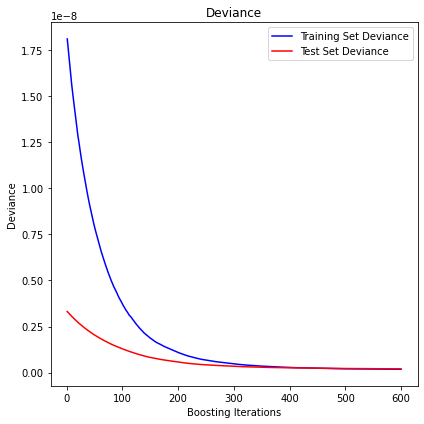

In [ ]:
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(gbr.staged_predict(X_test)):
    test_score[i] = gbr.loss_(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    gbr.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

Найдем параметры которые наиболее влияют на результат

In [ ]:
from sklearn.inspection import permutation_importance

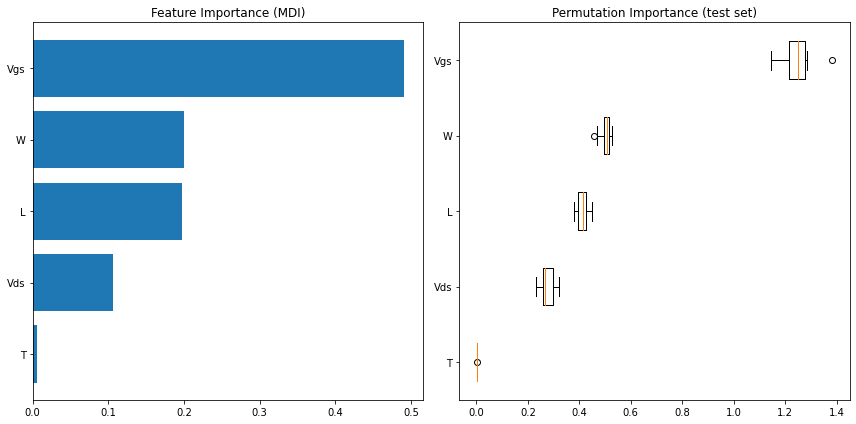

In [ ]:
feature_importance = gbr.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(['Vds', 'Vgs', 'L', 'W', 'T'])[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    gbr, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(['Vds', 'Vgs', 'L', 'W', 'T'])[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

In [ ]:
### Вычисляем точность
train_accuracy_score=gbr.score(X_train,y_train)
print(train_accuracy_score)

test_accuracy_score=gbr.score(X_test,y_test)
print(test_accuracy_score)

### Предсказание
y_pred = gbr.predict(X_test)

### И среднеквадратичную ошибку
mse = mean_squared_error(y_test,y_pred)
print("MSE: %.2f" % mse)
print(r2_score(y_test,y_pred))

0.9812779910971592
0.9796625543292964
MSE: 0.00
0.9796625543292964


In [ ]:
def process_data(df):
  Id=df["Id"]
  yval=np.ravel(Id)
  xval=df.iloc[:,0:5]

  xval = scl.transform(xval)
  return xval, yval, df

max loss:  8.068367138382756e-11
mean post-prox loss:  tf.Tensor(8.068367138382756e-11, shape=(), dtype=float64)


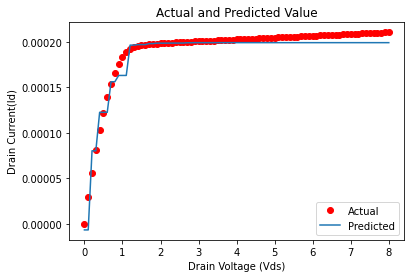

In [ ]:
plot_predict('mosfet_val_5.csv', gbr, process_data=process_data)

max loss:  2.2038888339520804e-10
mean post-prox loss:  tf.Tensor(2.2038888339520804e-10, shape=(), dtype=float64)


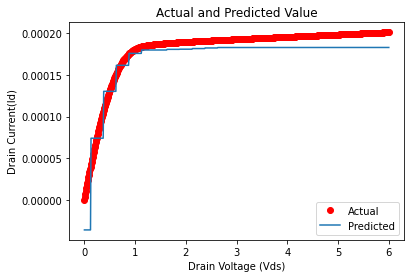

In [ ]:
plot_predict('mosfet_val_6.csv', gbr, process_data=process_data)

Посчитаем loss внутри области обучения

In [ ]:
df_val = pd.read_csv('data_val_in.csv')

id=df_val["Id"]
yval=np.ravel(id)
xval=df_val.iloc[:,0:5]
# print(xval)
y_pred = gbr.predict(xval)

print_loss(yval, y_pred)

max loss:  3.568937242536208e-08
mean post-prox loss:  tf.Tensor(3.568937242536208e-08, shape=(), dtype=float64)


Также посчитаем вне области обучения

In [ ]:
df_val = pd.read_csv('data_val_out.csv')
# print(df_val)

id=df_val["Id"]
yval=np.ravel(id)
xval=df_val.iloc[:,0:5]
# print(xval)
y_pred = gbr.predict(xval)

print_loss(yval, y_pred)

max loss:  2.431747680191425e-07
mean post-prox loss:  tf.Tensor(2.431747680191425e-07, shape=(), dtype=float64)


### CatBoost

In [ ]:
!pip install catboost
!pip install scikit-learn
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

In [ ]:
# catboost для регрессии
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor, Pool

In [ ]:
def process_data(df):
  Id=df["Id"]
  yval=np.ravel(Id)
  xval=df.iloc[:,0:5]

# применим преобразования что и при нормировке
  xval = scl.transform(xval)
  # yval = lbl.transform(yval)
  return xval, yval, df

In [ ]:
scl = StandardScaler()
scl.fit(X)
X_scaled = scl.transform(X)

In [ ]:
### Разбираемся с признаками

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.20, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
train_dataset = Pool(X_train, y_train)
train_dataset

In [ ]:
eval_dataset = Pool(X_test, y_test)
eval_dataset

In [ ]:
# Initialize CatBoostRegressor
model = CatBoostRegressor(iterations=1000,
                          use_best_model=True,
                          loss_function='RMSE',
                          task_type="GPU",
                          devices='0:1',
                          )

In [ ]:
# Fit model
model.fit(train_dataset,
          eval_set=(X_test, y_test),
          verbose=50,
          # plot_file='catboost.png',
          )

Learning rate set to 0.071423
0:	learn: 0.0001862	test: 0.0001921	best: 0.0001921 (0)	total: 15ms	remaining: 15s
50:	learn: 0.0000194	test: 0.0000215	best: 0.0000215 (50)	total: 583ms	remaining: 10.9s
100:	learn: 0.0000123	test: 0.0000134	best: 0.0000134 (99)	total: 954ms	remaining: 8.49s
150:	learn: 0.0000113	test: 0.0000123	best: 0.0000123 (150)	total: 1.3s	remaining: 7.3s
200:	learn: 0.0000089	test: 0.0000098	best: 0.0000098 (200)	total: 1.62s	remaining: 6.45s
250:	learn: 0.0000069	test: 0.0000076	best: 0.0000076 (250)	total: 2.01s	remaining: 5.99s
300:	learn: 0.0000066	test: 0.0000073	best: 0.0000073 (300)	total: 2.33s	remaining: 5.4s
350:	learn: 0.0000061	test: 0.0000068	best: 0.0000068 (350)	total: 2.64s	remaining: 4.88s
400:	learn: 0.0000058	test: 0.0000065	best: 0.0000065 (400)	total: 2.93s	remaining: 4.38s
450:	learn: 0.0000056	test: 0.0000063	best: 0.0000063 (450)	total: 3.25s	remaining: 3.95s
500:	learn: 0.0000054	test: 0.0000061	best: 0.0000061 (500)	total: 3.54s	remaining:

In [ ]:
print(model.get_best_iteration())

999


In [ ]:
print(model.get_best_score())

{'learn': {'RMSE': 4.533605162205458e-06}, 'validation': {'RMSE': 5.207987726333353e-06}}


max loss:  5.400383666143354e-11
mean post-prox loss:  tf.Tensor(5.400383666143354e-11, shape=(), dtype=float64)


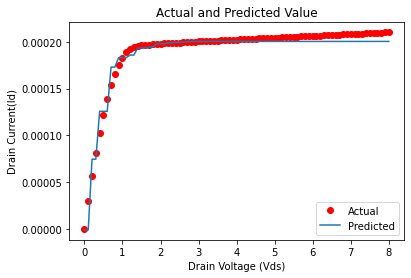

In [ ]:
plot_predict('mosfet_val_5.csv', model, process_data=process_data)

max loss:  2.0357455572432337e-10
mean post-prox loss:  tf.Tensor(2.0357455572432337e-10, shape=(), dtype=float64)


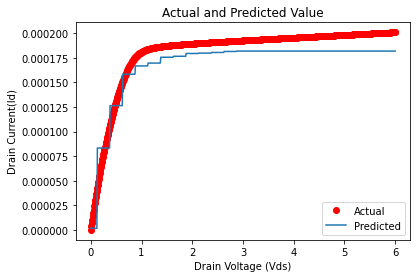

In [ ]:
plot_predict('mosfet_val_6.csv', model, process_data=process_data)

In [ ]:
df_val = pd.read_csv('data_val_in.csv')
# print(df_val)

id=df_val["Id"]
yval=np.ravel(id)
xval=df_val.iloc[:,0:5]
# print(xval)
y_pred = model.predict(xval)

print_loss(yval, y_pred)

max loss:  3.582875214004598e-08
mean post-prox loss:  tf.Tensor(3.582875214004598e-08, shape=(), dtype=float64)


In [ ]:
df_val = pd.read_csv('data_val_out.csv')
# print(df_val)

id=df_val["Id"]
yval=np.ravel(id)
xval=df_val.iloc[:,0:5]
# print(xval)
y_pred = model.predict(xval)

print_loss(yval, y_pred)

max loss:  2.3991477533486314e-07
mean post-prox loss:  tf.Tensor(2.3991477533486314e-07, shape=(), dtype=float64)


Переберем некоторые параметры и найдем более лучшие параметры

In [ ]:
model = CatBoostRegressor(
    task_type="GPU",
    devices='0:1',
)

params = {
            'iterations':[10, 50, 100, 500, 1000],
            'learning_rate': [1, 0.1, 0.05, 0.03, 0.01, 0.005],
            'depth': [4, 6, 10, 12],
            'l2_leaf_reg': [1, 3, 5, 7, 9],
            'bootstrap_type':['Bayesian', 'No'],
}

grid_search_result = model.grid_search(params, X_scaled, y)

Выходные данные были обрезаны до нескольких последних строк (5000).
16:	learn: 0.0002279	test: 0.0002299	best: 0.0002299 (16)	total: 531ms	remaining: 30.7s
17:	learn: 0.0002269	test: 0.0002289	best: 0.0002289 (17)	total: 634ms	remaining: 34.6s
18:	learn: 0.0002259	test: 0.0002280	best: 0.0002280 (18)	total: 644ms	remaining: 33.2s
19:	learn: 0.0002249	test: 0.0002270	best: 0.0002270 (19)	total: 663ms	remaining: 32.5s
20:	learn: 0.0002240	test: 0.0002260	best: 0.0002260 (20)	total: 676ms	remaining: 31.5s
21:	learn: 0.0002230	test: 0.0002251	best: 0.0002251 (21)	total: 686ms	remaining: 30.5s
22:	learn: 0.0002221	test: 0.0002241	best: 0.0002241 (22)	total: 699ms	remaining: 29.7s
23:	learn: 0.0002211	test: 0.0002232	best: 0.0002232 (23)	total: 711ms	remaining: 28.9s
24:	learn: 0.0002202	test: 0.0002222	best: 0.0002222 (24)	total: 741ms	remaining: 28.9s
25:	learn: 0.0002192	test: 0.0002213	best: 0.0002213 (25)	total: 751ms	remaining: 28.1s
26:	learn: 0.0002183	test: 0.0002204	best: 0.0002204

In [ ]:
print("\nBest Params : ", grid_search_result['params'])


Best Params :  {'depth': 10, 'learning_rate': 1, 'l2_leaf_reg': 5, 'iterations': 1000, 'bootstrap_type': 'No'}


In [ ]:
print(model.get_best_score())

{'learn': {'RMSE': 2.0273536242799463e-06}}


In [ ]:
print("Best Score                : ",model.best_score_)
# print("List of Target Classses : ",model.classes_)
print("Data Feature Names      : ",model.feature_names_)
print("Feature Importance      : ", model.feature_importances_)
print("Learning Rate           : ",model.learning_rate_)
print("Random Seed             : ",model.random_seed_)
print("Number of Trees         : ",model.tree_count_)
print("Number of Features      : ",model.n_features_in_)

Best Score                :  {'learn': {'RMSE': 2.0273536242799463e-06}}
Data Feature Names      :  ['0', '1', '2', '3', '4']
Feature Importance      :  [27.8480115  21.61061913 20.43367341 29.78897029  0.31872567]
Learning Rate           :  1
Random Seed             :  0
Number of Trees         :  1000
Number of Features      :  5


max loss:  5.09408486713142e-11
mean post-prox loss:  tf.Tensor(5.09408486713142e-11, shape=(), dtype=float64)


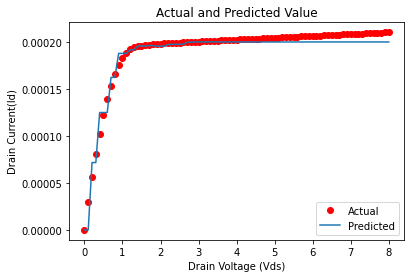

In [ ]:
plot_predict('mosfet_val_5.csv', model, process_data=process_data)

max loss:  9.08030173620967e-11
mean post-prox loss:  tf.Tensor(9.08030173620967e-11, shape=(), dtype=float64)


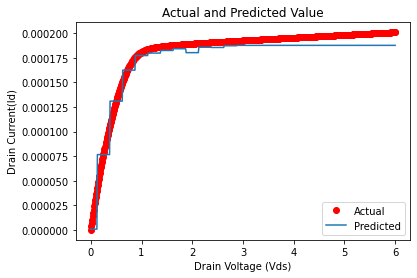

In [ ]:
plot_predict('mosfet_val_6.csv', model, process_data=process_data)

In [ ]:
df_val = pd.read_csv('data_val_in.csv')
# print(df_val)

id=df_val["Id"]
yval=np.ravel(id)
xval=df_val.iloc[:,0:5]
# print(xval)
y_pred = model.predict(xval)

print_loss(yval, y_pred)

max loss:  3.618703431996948e-08
mean post-prox loss:  tf.Tensor(3.618703431996948e-08, shape=(), dtype=float64)


In [ ]:
df_val = pd.read_csv('data_val_out.csv')
# print(df_val)

id=df_val["Id"]
yval=np.ravel(id)
xval=df_val.iloc[:,0:5]
# print(xval)
y_pred = model.predict(xval)

print_loss(yval, y_pred)

max loss:  2.4085346395729483e-07
mean post-prox loss:  tf.Tensor(2.4085346395729483e-07, shape=(), dtype=float64)


# Нейронный сети

## Подготовка данных

Напишем модели подготовки данных

In [3]:
# Split train and test dataset
from sklearn.model_selection import train_test_split

In [4]:
class ProcessDataSimple(object):
  """Миксин создания модели подготовки данных"""
  def __init__(self, df, test_size=0.2, random_state=42):

    X, y = self._split_x_y(df)
    X_train, X_test, y_train, y_test = self._split_train_test(
        X, y, test_size=test_size, random_state=random_state
        )
    
    self.X_train = X_train
    self.X_test = X_test
    self.y_train = y_train
    self.y_test = y_test


  def _split_x_y(self, df):
    """разделение df на X и Y"""
    X = df.iloc[:,0:5]
    y = np.ravel(df["Id"])
    return X, y


  def _split_train_test(self, X, y, test_size, random_state):
    """разделение на train и test"""
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, 
                                                        random_state=random_state)
    return X_train, X_test, y_train, y_test


  def transform(self, df):
    """функция подготовки данных
        return: X и y"""
    return self._split_x_y(df)

  def retransform_y(self, y):
    """функция перевода,
     полученного Y в нормальный вид"""
    return y

In [5]:
from sklearn import preprocessing

In [6]:
# NEED CHANGE
class ProcessData(ProcessDataSimple):
  """Приводим данные к формату от 0 до 1"""
  def __init__(self, df, test_size=0.2, random_state=42):
    X, y = self._split_x_y(df)
    X, self.scaler_X = self._scaler(X)

    X_train, X_test, y_train, y_test = self._split_train_test(
        X, y, test_size=test_size, random_state=random_state,
        )
    
    self.X_train = X_train
    self.X_test = X_test
    self.y_train = y_train
    self.y_test = y_test


  def _scaler(self, X):
    """получение SCALER для X"""
    scaler = preprocessing.MinMaxScaler().fit(X)
    X_scaled = scaler.transform(X)
    return X_scaled, scaler


  def transform(self, df):
    X, y = self._split_x_y(df)
    return self.scaler_X.transform(X), y

  def retransform_y(self, y):
    return y

In [7]:
class ProcessDataMinMax(ProcessDataSimple):
  """Действуем на данные MinMaxScaler"""

  def __init__(self, df, test_size=0.2, random_state=42):
    data = df.copy()

    X, y = self._split_x_y(df)

    self.scaler_X, self.scaler_Y = self._scaler(data)

    X_train, X_test, y_train, y_test = self._split_train_test(
        X, y, test_size=test_size, random_state=random_state
        )
    
    self.data = data
    self.X_train = X_train
    self.X_test = X_test
    self.y_train = y_train
    self.y_test = y_test


  def _scaler(self, data):
    scaler_X = preprocessing.MinMaxScaler().fit(data.iloc[:,0:5])
    data.iloc[:,0:5] = scaler_X.transform(data.iloc[:,0:5])

    y = data.loc[:, 'Id'].values.reshape(-1, 1)
    scaler_Y = preprocessing.MinMaxScaler().fit(y)
    data.loc[:, 'Id'] = scaler_Y.transform(y)
    return scaler_X, scaler_Y


  def transform(self, df):
    data = df.copy()

    X, y = self._split_x_y(data)
    return self.scaler_X.transform(X), self.scaler_Y.transform(y.reshape(-1, 1))

  def retransform_y(self, y):
    y = (self.scaler_Y.data_max_ - self.scaler_Y.data_min_) * y + self.scaler_Y.data_min_
    return y

In [8]:
class ProcessDataStd(ProcessDataSimple):
  """Действуем на данные StandartScaler"""

  def __init__(self, df, test_size=0.2, random_state=42):
    data = df.copy()

    X, y = self._split_x_y(data)

    self.scaler_X, self.scaler_Y = self._scaler(data)

    X_train, X_test, y_train, y_test = self._split_train_test(
        X, y, test_size=test_size, random_state=random_state
        )
    
    self.data = data
    self.X_train = X_train
    self.X_test = X_test
    self.y_train = y_train
    self.y_test = y_test


  def _scaler(self, data):
    scaler_X = preprocessing.StandardScaler().fit(data.iloc[:,0:5])
    data.iloc[:,0:5] = scaler_X.transform(data.iloc[:,0:5])

    y = data.loc[:, 'Id'].values.reshape(-1, 1)
    scaler_Y = preprocessing.StandardScaler().fit(y)
    data.loc[:, 'Id'] = scaler_Y.transform(y)
    return scaler_X, scaler_Y


  def transform(self, df):
    data = df.copy()
    X, y = self._split_x_y(data)
    return self.scaler_X.transform(X), self.scaler_Y.transform(y.reshape(-1, 1))

  def retransform_y(self, y):
    y = y * self.scaler_Y.scale_ + self.scaler_Y.mean_
    return y

In [9]:
# NEED CHANGE
class ProcessDataLog(ProcessDataSimple):
  """Действуем на X функцией log10
      На Y функцией - 1 / log10"""

  REPLACE_ZERO_ID = 1e-20
  REPLACE_ZERO_VGS = 1e-3
  REPLACE_ZERO_VDS = 1e-3
  REPLACE_ZERO_T = 1e-3

  def __init__(self, df, test_size=0.2, random_state=42):
    data  = df.copy()
    self._replace_X(data)
    self._replace_y(data)

    self._log_x(data)
    self._log_y(data)

    X, y = self._split_x_y(data)

    X_train, X_test, y_train, y_test = self._split_train_test(
        X, y, test_size=test_size, random_state=random_state
        )
    
    self.X_train = X_train
    self.X_test = X_test
    self.y_train = y_train
    self.y_test = y_test

  def _replace_y(self, data):
    # замена отрицательных значений на нули
    data.loc[data["Id"] < 0, "Id"] = 0
    # Replace zeros
    data["Id"].replace({0:self.REPLACE_ZERO_ID}, inplace=True)

  def _replace_X(self, data):
    # Replace zeros
    data["Vgs"].replace({0:self.REPLACE_ZERO_VGS}, inplace=True)
    data["Vds"].replace({0:self.REPLACE_ZERO_VDS}, inplace=True)
    data["T"].replace({0:self.REPLACE_ZERO_T}, inplace=True)
  
  def _log_x(self, data):
    data.loc[:, 'Vds'] = data['Vds'].apply(np.log10)
    data.loc[:, 'Vgs'] = data['Vgs'].apply(np.log10)

  def _log_y(self, data):
    data.loc[:, 'Id'] = data['Id'].apply(lambda x: -1/np.log10(x))


  def transform(self, df):
    data = df.copy()
    self._replace_X(data)
    self._replace_y(data)

    self._log_x(data)
    self._log_y(data)

    X, y = self._split_x_y(data)
    return X, y

  def retransform_y(self, y):
    # y_new = (y - min) / (max - min)
    # return y * (self.scaler_y.data_max_ - self.scaler_y.data_min_) + self.scaler_y.data_min_
    return 10 ** (-1 / y)

In [10]:
class ProcessDataLogNorm(ProcessDataLog):
  """Действуем на данные функцией с LOG10 и нормализируем тестувую выборку"""

  def __init__(self, df, test_size=0.2, random_state=42):
    data = df.copy()
    self._replace_X(data)
    self._replace_y(data)

    self._log_x(data)
    self._log_y(data)

    X, y = self._split_x_y(data)

    self.scaler_X, self.scaler_Y = self._scaler(data)

    X_train, X_test, y_train, y_test = self._split_train_test(
        X, y, test_size=test_size, random_state=random_state
        )
    
    self.data = data
    self.X_train = X_train
    self.X_test = X_test
    self.y_train = y_train
    self.y_test = y_test


  def _scaler(self, data):
    scaler_X = preprocessing.StandardScaler().fit(data.iloc[:,0:5])
    data.iloc[:,0:5] = scaler_X.transform(data.iloc[:,0:5])

    y = data.loc[:, 'Id'].values.reshape(-1, 1)
    scaler_Y = preprocessing.StandardScaler().fit(y)
    data.loc[:, 'Id'] = scaler_Y.transform(y)
    return scaler_X, scaler_Y


  def transform(self, df):
    data = df.copy()
    self._replace_X(data)
    self._replace_y(data)

    self._log_x(data)
    self._log_y(data)

    X, y = self._split_x_y(data)
    return self.scaler_X.transform(X), self.scaler_Y.transform(y.reshape(-1, 1))

  def retransform_y(self, y_in):
    y = y_in.copy()
    y = y * self.scaler_Y.scale_ + self.scaler_Y.mean_
    return 10 ** (-1 / y)

In [ ]:
df = pd.read_csv('mosfet_simple.csv')
df.head()

,Vds,Vgs,L,W,T,Id
0,0.00,0.0,2.000000e-07,2.000000e-07,0.0,-1.205876e-28
1,0.25,0.0,2.000000e-07,2.000000e-07,0.0,6.993572e-13
2,0.50,0.0,2.000000e-07,2.000000e-07,0.0,1.252304e-12
3,0.75,0.0,2.000000e-07,2.000000e-07,0.0,1.814132e-12
4,1.00,0.0,2.000000e-07,2.000000e-07,0.0,2.387202e-12


In [ ]:
data_simple = ProcessDataSimple(df)
data_0 = ProcessData(df)
data_minmax = ProcessDataMinMax(df)
data_std = ProcessDataStd(df)
data_log = ProcessDataLog(df)
data_lognorm = ProcessDataLogNorm(df)

In [ ]:
# data.data.head()

In [ ]:
# data.data.describe()

In [ ]:
# print(data.y_train.mean(), data.y_train.std())
# data.y_train

In [ ]:
# data.retransform_y(data.transform(df)[1])

In [ ]:
def create_model():
  model = tf.keras.Sequential()

  model.add(keras.layers.Dense(30, activation='tanh', input_shape=(5,)))
  model.add(keras.layers.Dense(20, activation='tanh'))
  model.add(keras.layers.Dense(1, activation='sigmoid'))

  model.compile(optimizer='adam', loss='mse', metrics=['mae'])
  # model.summary()
  return model

In [ ]:
def fit_model(data):
  t1 = time.perf_counter()
  model = create_model()
  history = model.fit(data.X_train, data.y_train, epochs=1000, verbose=0, validation_data=(data.X_test, data.y_test))
  print('LAST loss: ', history.history['loss'][-1], 'val_loss: ', history.history['val_loss'][-1])
  print('TIME:',time.perf_counter()-t1)
  y_pred = model.predict(data.transform(df)[0])
  print_loss(df['Id'], data.retransform_y(y_pred))
  return model

In [ ]:
model_simple = fit_model(data_simple)

LAST loss:  1.9899131231682077e-08 val_loss:  2.0510190879008405e-08
TIME: 262.4624988739997
MAX loss:  1.4728765e-07 mae:  0.0003608598
MEAN loss:  5.749321e-08 mae:  0.00017165083
MAX value:  6.027261203716059e-08 mae: 0.00014322818808514193
MEAN value:  6.027261203716059e-08 mae: 0.00014322818808514193


In [ ]:
model_0 = fit_model(data_0)

LAST loss:  4.406452980276754e-09 val_loss:  4.061532443699889e-09
TIME: 262.4162160169981
MAX loss:  9.646113e-07 mae:  0.00096172735
MEAN loss:  7.4523335e-08 mae:  0.0001832446
MAX value:  6.027261203716059e-08 mae: 0.00014322818808514193
MEAN value:  6.027261203716059e-08 mae: 0.00014322818808514193


In [ ]:
model_minmax = fit_model(data_minmax)

LAST loss:  1.9894432767841863e-08 val_loss:  2.0347851403812456e-08
TIME: 262.42042981600025
MAX loss:  6.026906317065489e-08 mae:  0.00014322083028465342
MEAN loss:  6.026575619427558e-08 mae:  0.00014321433531092506
MAX value:  6.027261203716059e-08 mae: 0.00014322818808514193
MEAN value:  6.027261203716059e-08 mae: 0.00014322818808514193


In [ ]:
model_std = fit_model(data_std)

LAST loss:  0.5132084488868713 val_loss:  0.5664559006690979
TIME: 318.96033953000006
MAX loss:  7.95165963500156e-08 mae:  0.00025746082738086867
MEAN loss:  4.713142340508208e-08 mae:  0.00016793542768801423
MAX value:  6.027261203716059e-08 mae: 0.00014322818808514193
MEAN value:  6.027261203716059e-08 mae: 0.00014322818808514193


In [ ]:
model_log = fit_model(data_log)

LAST loss:  0.00036101433215662837 val_loss:  0.0003405324532650411
TIME: 262.43492125800185
MAX loss:  9.643314e-08 mae:  0.00028692163
MEAN loss:  5.5237884e-08 mae:  0.0001646917
MAX value:  6.027261203716059e-08 mae: 0.00014322818808514193
MEAN value:  6.027261203716059e-08 mae: 0.00014322818808514193


In [ ]:
model_lognorm = fit_model(data_lognorm)

LAST loss:  0.6578012704849243 val_loss:  0.6445431709289551
TIME: 269.46681727399846
MAX loss:  9.278249548963789e-08 mae:  0.0002808438073086381
MEAN loss:  5.603077145922534e-08 mae:  0.000163921594901349
MAX value:  6.027261203716059e-08 mae: 0.00014322818808514193
MEAN value:  6.027261203716059e-08 mae: 0.00014322818808514193


In [ ]:
def scheduler(epoch, lr):
  if epoch < 100:
    return 1.0
  elif 100 <= epoch < 600:
    return 0.03
  else:
    return 0.001

# def scheduler(epoch, lr):
#     decay_rate = 0.1
#     decay_step = 90
#     if epoch % decay_step == 0 and epoch:
#         return lr * decay_rate
#     return lr


model_call = create_model()
history_call = model_call.fit(data_lognorm.X_train, data_lognorm.y_train, 
                              epochs=1000, verbose=0, 
                              validation_data=(data_lognorm.X_test, data_lognorm.y_test), 
                              callbacks=[tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=0),
])

y_pred_call = model_call.predict(data_lognorm.transform(df)[0])
print_loss(df['Id'], data_lognorm.retransform_y(y_pred_call))

MAX loss:  5.5033626000926106e-08 mae:  0.00013608738197532535
MEAN loss:  5.503362600091045e-08 mae:  0.00013608738197530817
MAX value:  6.027261203716059e-08 mae: 0.00014322818808514193
MEAN value:  6.027261203716059e-08 mae: 0.00014322818808514193


In [ ]:
model_call.optimizer.lr.numpy()

0.001

Посмотрим на то на сколько хорошо предсказывает наша сеть

Параметры внутри области обучения

MAX loss:  2.0514314212255824e-08 mae:  0.00014322818930732813
MEAN loss:  1.7448542284350025e-09 mae:  3.4976556962662634e-05
MAX value:  4.0384967380429225e-08 mae: 0.0002009601139043
MEAN value:  3.3797255937217286e-08 mae: 0.0001795683449757238
MAX loss:  3.3797257e-08 mae:  0.00017956833
MEAN loss:  4.1174273e-09 mae:  4.154621e-05
MAX value:  3.3797255937217286e-08 mae: 0.00017956834497572384
MEAN value:  3.3797255937217286e-08 mae: 0.00017956834497572384
MAX loss:  7.918386822077697e-10 mae:  2.81396283239095e-05
MEAN loss:  2.680031084336833e-10 mae:  1.5425765731844793e-05
MAX value:  4.038496738042925e-08 mae: 0.0002009601139043
MEAN value:  3.379725593721729e-08 mae: 0.00017956834497572384


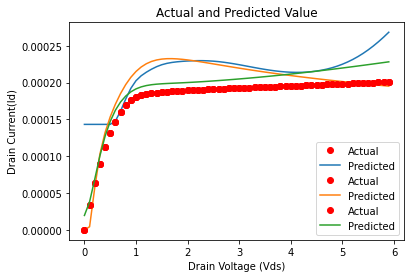

In [ ]:
# plot_predict('mosfet_val_3.csv', model_simple, process_data=data_simple.transform, reprocess_data=data_simple.retransform_y)
# plot_predict('mosfet_val_3.csv', model_0, process_data=data_0.transform, reprocess_data=data_0.retransform_y)
# plot_predict('mosfet_val_3.csv', model_minmax, process_data=data_minmax.transform, reprocess_data=data_minmax.retransform_y)
plot_predict('mosfet_val_3.csv', model_std, process_data=data_std.transform, reprocess_data=data_std.retransform_y)
plot_predict('mosfet_val_3.csv', model_log, process_data=data_log.transform, reprocess_data=data_log.retransform_y)
plot_predict('mosfet_val_3.csv', model_lognorm, process_data=data_lognorm.transform, reprocess_data=data_lognorm.retransform_y)
# plot_predict('mosfet_val_3.csv', model_call, process_data=data_lognorm.transform, reprocess_data=data_lognorm.retransform_y)
# plt.legend()

Параметры вне области обучения

MAX loss:  2.0514314212255824e-08 mae:  0.00014322818930732813
MEAN loss:  1.5606079481931865e-09 mae:  3.38132003692315e-05
MAX value:  4.038496738034883e-08 mae: 0.0002009601139040999
MEAN value:  3.400085626909417e-08 mae: 0.0001808013706695494
MAX loss:  3.4000855e-08 mae:  0.00018080136
MEAN loss:  3.6164423e-09 mae:  3.9558305e-05
MAX value:  3.400085626909417e-08 mae: 0.00018080137066954938
MEAN value:  3.400085626909417e-08 mae: 0.00018080137066954938
MAX loss:  7.918368232214899e-10 mae:  2.8139595292425403e-05
MEAN loss:  2.6112681839776874e-10 mae:  1.522203299648724e-05
MAX value:  4.0384967380348836e-08 mae: 0.00020096011390409994
MEAN value:  3.400085626909417e-08 mae: 0.0001808013706695494


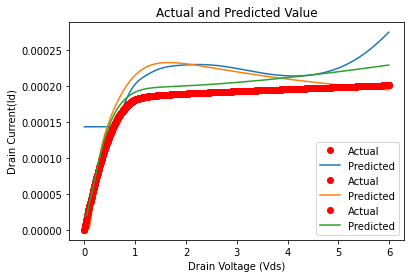

In [ ]:
# plot_predict('mosfet_val_3.csv', model_simple, process_data=data_simple.transform, reprocess_data=data_simple.retransform_y)
# plot_predict('mosfet_val_3.csv', model_0, process_data=data_0.transform, reprocess_data=data_0.retransform_y)
# plot_predict('mosfet_val_3.csv', model_minmax, process_data=data_minmax.transform, reprocess_data=data_minmax.retransform_y)
plot_predict('mosfet_val_6.csv', model_std, process_data=data_std.transform, reprocess_data=data_std.retransform_y)
plot_predict('mosfet_val_6.csv', model_log, process_data=data_log.transform, reprocess_data=data_log.retransform_y)
plot_predict('mosfet_val_6.csv', model_lognorm, process_data=data_lognorm.transform, reprocess_data=data_lognorm.retransform_y)
# plot_predict('mosfet_val_6.csv', model_call, process_data=data_lognorm.transform, reprocess_data=data_lognorm.retransform_y)
# plt.legend()

## Построение модели

**Import Tensorflow and Keras**

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
tf.test.gpu_device_name()

''

Загрузим датасет

In [17]:
df = pd.read_csv('../dataset_csv/mosfet_noise_5.csv')

Выберем способ подготовки данных

Import hyperopt

In [ ]:
!pip install -U hyperopt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 2.1 MB/s 
     |████████████████████████████████| 200 kB 54.5 MB/s 
  Attempting uninstall: hyperopt
    Found existing installation: hyperopt 0.1.2
    Uninstalling hyperopt-0.1.2:
      Successfully uninstalled hyperopt-0.1.2


Будем использовать фреймворк Hyperopt для поиска оптимальных параметров нейросети. 

Сущеуствует различные способы находить оптимальные параметры:

1. Поиск по решётке
2. Случайный поиск.
3. Байесовская оптимизация

Давайте дадим примениние байесовской оптимизацией (с использованием Tree Parzen Estimator или TPE)

In [ ]:
import hyperopt

import warnings

warnings.filterwarnings("ignore")

print("Hyperopt Version : {}".format(hyperopt.__version__))

Hyperopt Version : 0.2.7


Установим Callbacks для обучающихся моделей

In [ ]:
# def scheduler(epoch, lr):
#   if epoch < 100:
#     return 1.0
#   elif 100 <= epoch < 600:
#     return 0.03
#   else:
#     return 0.001

In [ ]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=20, monitor='loss'),
    tf.keras.callbacks.TerminateOnNaN(),
    # keras.callbacks.LearningRateScheduler(schedule, verbose=0),
    # tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    # tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

Напишем функцию, которую необходимо будет оптимизировать

In [ ]:
data_std = ProcessDataStd(df)
data_log = ProcessDataLog(df)
data_lognorm = ProcessDataLogNorm(df)

process_data = {
    'data_std': data_std,
    'data_log': data_log,
    'data_lognorm': data_lognorm,
}

In [ ]:
from sklearn.metrics import mean_squared_error

def objective(args):
    model = tf.keras.Sequential()

    model.add(keras.layers.Dense(args['layers_1'], activation=args['activation_1'], input_shape=(5,)))
    model.add(keras.layers.Dense(args['layers_2'], activation=args['activation_2']))
    model.add(keras.layers.Dense(1, activation=args['activation_out']))

    model.compile(optimizer=args['optimizer'], loss=args['loss'], metrics=['mae'])

    data = process_data[args['process']]

    model.fit(data.X_train, data.y_train, epochs=1000, batch_size=128, shuffle=True, verbose=0, callbacks=my_callbacks)

    y_pred = model.predict(data.X_test)

    print("Hyperparameters : {}".format(args)) ## This can be commented if not needed.

    # ans = mean_squared_error(data.retransform_y(data.y_test), data.retransform_y(y_pred))

    try:
      ans = mean_squared_error(data.retransform_y(data.y_test), data.retransform_y(y_pred))
    except:
      ans = 1

    print("MSE : {}\n".format(ans))

    if ans == None:
      ans = 1

    return ans

Образуем область поиска

In [ ]:
from hyperopt import hp

In [ ]:
# data = ProcessDataLogNorm(df)

In [ ]:
search_space = {
    'layers_1': [5, 10, 15, 20, 25, 30, 35, 40],
    'layers_2': [5, 10, 15, 20, 25, 30, 35, 40],
    'activation_1': ['softmax', 'relu', 'tanh', 'sigmoid', 'linear'],
    'activation_2': ['softmax', 'relu', 'tanh', 'sigmoid', 'linear'],
    'activation_out': ['softmax', 'tanh', 'sigmoid'],
    'optimizer': ['SGD', 'Adam'],
    'loss': ['mse', 'mae'],
    'process': ['data_std', 'data_log', 'data_lognorm']
}

In [ ]:
hp_search_space = {
    'layers_1': hp.choice('layers_1', search_space['layers_1']),
    'layers_2': hp.choice('layers_2', search_space['layers_2']),

    'activation_1': hp.choice('activation_1', search_space['activation_1']),
    'activation_2': hp.choice('activation_2', search_space['activation_2']),
    'activation_out': hp.choice('activation_out', search_space['activation_out']),

    'optimizer': hp.choice('optimizer', search_space['optimizer']),
    'loss': hp.choice('loss', search_space['loss']),
    'process': hp.choice('process', search_space['process']),
}

Начнем процесс оптимизации

In [ ]:
trials_obj = hyperopt.Trials()

t1 = time.perf_counter()

best_results = hyperopt.fmin(objective,
                             space=hp_search_space,
                             algo=hyperopt.tpe.suggest,
                             max_evals=100,
                             trials=trials_obj,
                            #  show_progressbar=True,
                            )

print('time taken to run:',time.perf_counter()-t1)

Hyperparameters : {'activation_1': 'relu', 'activation_2': 'linear', 'activation_out': 'softmax', 'layers_1': 10, 'layers_2': 5, 'loss': 'mae', 'optimizer': 'Adam', 'process': 'data_log'}
MSE : 0.009971090013811919

Hyperparameters : {'activation_1': 'tanh', 'activation_2': 'sigmoid', 'activation_out': 'tanh', 'layers_1': 5, 'layers_2': 10, 'loss': 'mae', 'optimizer': 'Adam', 'process': 'data_log'}
MSE : 2.1397884209609136e-08

Hyperparameters : {'activation_1': 'sigmoid', 'activation_2': 'tanh', 'activation_out': 'sigmoid', 'layers_1': 30, 'layers_2': 40, 'loss': 'mse', 'optimizer': 'SGD', 'process': 'data_std'}
MSE : 2.1638594344602784e-08

Hyperparameters : {'activation_1': 'sigmoid', 'activation_2': 'linear', 'activation_out': 'tanh', 'layers_1': 10, 'layers_2': 25, 'loss': 'mse', 'optimizer': 'Adam', 'process': 'data_std'}
MSE : 1.238845523695842e-08

Hyperparameters : {'activation_1': 'softmax', 'activation_2': 'tanh', 'activation_out': 'tanh', 'layers_1': 35, 'layers_2': 25, 'lo

Лучший результат:

In [ ]:
print(best_results)

{'activation_1': 1, 'activation_2': 0, 'activation_out': 1, 'layers_1': 4, 'layers_2': 5, 'loss': 1, 'optimizer': 1, 'process': 2}


In [ ]:
def show_params(best_results):
  ans = {}
  for name, ind in best_results.items():
    ans[name] = search_space[name][ind]
  return ans

show_params(best_results)

{'activation_1': 'relu',
 'activation_2': 'softmax',
 'activation_out': 'tanh',
 'layers_1': 25,
 'layers_2': 30,
 'loss': 'mae',
 'optimizer': 'Adam',
 'process': 'data_lognorm'}

In [ ]:
import json

# Save the trial results
with open('best_results.json', 'w') as f:
    f.write(json.dumps(show_params(best_results)))

In [ ]:
# Лучшие loss
# trials_obj_results = sorted(trials_obj.results, key = lambda x: x['loss'])
# trials_obj_results[:5]

In [ ]:
# Dataframe of results from optimization
tpe_results = pd.DataFrame({'val_loss': [x['loss'] for x in trials_obj.results], 
                            'iteration': trials_obj.idxs_vals[0]['layers_1'],
                            'activation_1': trials_obj.idxs_vals[1]['activation_1'],
                            'activation_2': trials_obj.idxs_vals[1]['activation_2'],
                            'activation_out': trials_obj.idxs_vals[1]['activation_out'],
                            'layers_1': trials_obj.idxs_vals[1]['layers_1'],
                            'layers_2': trials_obj.idxs_vals[1]['layers_2'],
                            'loss': trials_obj.idxs_vals[1]['loss'],
                            'optimizer': trials_obj.idxs_vals[1]['optimizer'],
                            'process': trials_obj.idxs_vals[1]['process'],
                            })
                            
tpe_results.head()

,val_loss,iteration,activation_1,activation_2,activation_out,layers_1,layers_2,loss,optimizer,process
0,9.971090e-03,0,1,4,0,1,0,1,1,1
1,2.139788e-08,1,2,3,1,0,1,1,1,1
2,2.163859e-08,2,3,2,2,5,7,0,0,0
3,1.238846e-08,3,3,4,1,1,4,0,1,0
4,2.691839e-08,4,0,2,1,6,4,1,0,1


In [ ]:
def _fun(name, lst):
  return [search_space[name][x] for x in lst]

tpe_results = pd.DataFrame({'val_loss': [x['loss'] for x in trials_obj.results], 
                            'iteration': trials_obj.idxs_vals[0]['layers_1'],
                            'activation_1': _fun('activation_1', trials_obj.idxs_vals[1]['activation_1']),
                            'activation_2': _fun('activation_2', trials_obj.idxs_vals[1]['activation_2']),
                            'activation_out': _fun('activation_out', trials_obj.idxs_vals[1]['activation_out']),
                            'layers_1': _fun('layers_1', trials_obj.idxs_vals[1]['layers_1']),
                            'layers_2': _fun('layers_2', trials_obj.idxs_vals[1]['layers_2']),
                            'loss': _fun('loss', trials_obj.idxs_vals[1]['loss']),
                            'optimizer': _fun('optimizer', trials_obj.idxs_vals[1]['optimizer']),
                            'process': _fun('process', trials_obj.idxs_vals[1]['process']),
                            })
                            
tpe_results.head()

,val_loss,iteration,activation_1,activation_2,activation_out,layers_1,layers_2,loss,optimizer,process
0,9.971090e-03,0,relu,linear,softmax,10,5,mae,Adam,data_log
1,2.139788e-08,1,tanh,sigmoid,tanh,5,10,mae,Adam,data_log
2,2.163859e-08,2,sigmoid,tanh,sigmoid,30,40,mse,SGD,data_std
3,1.238846e-08,3,sigmoid,linear,tanh,10,25,mse,Adam,data_std
4,2.691839e-08,4,softmax,tanh,tanh,35,25,mae,SGD,data_log


In [ ]:
tpe_results.to_csv('tpe_results.csv', index = False)

In [ ]:
top_results = tpe_results.sort_values(by='val_loss', ascending=True)[:10]
top_results

,val_loss,iteration,activation_1,activation_2,activation_out,layers_1,layers_2,loss,optimizer,process
82,1.045662e-08,82,relu,softmax,tanh,25,30,mae,Adam,data_lognorm
72,1.046065e-08,72,relu,sigmoid,tanh,30,15,mae,Adam,data_lognorm
90,1.046205e-08,90,relu,softmax,tanh,25,30,mae,Adam,data_lognorm
85,1.046517e-08,85,relu,softmax,tanh,25,30,mae,Adam,data_lognorm
79,1.046630e-08,79,relu,softmax,tanh,30,15,mae,Adam,data_lognorm
67,1.047277e-08,67,sigmoid,tanh,tanh,10,25,mae,Adam,data_lognorm
71,1.047559e-08,71,sigmoid,tanh,tanh,30,15,mae,Adam,data_lognorm
69,1.047828e-08,69,sigmoid,tanh,tanh,30,15,mae,Adam,data_lognorm
70,1.047924e-08,70,sigmoid,tanh,tanh,30,15,mae,Adam,data_lognorm
65,1.048424e-08,65,sigmoid,tanh,tanh,10,25,mae,Adam,data_lognorm


In [ ]:
# print("Loss Value of Best Trial : {}".format(best_trial['result']['loss']))

Text(0.5, 1.0, 'activation')

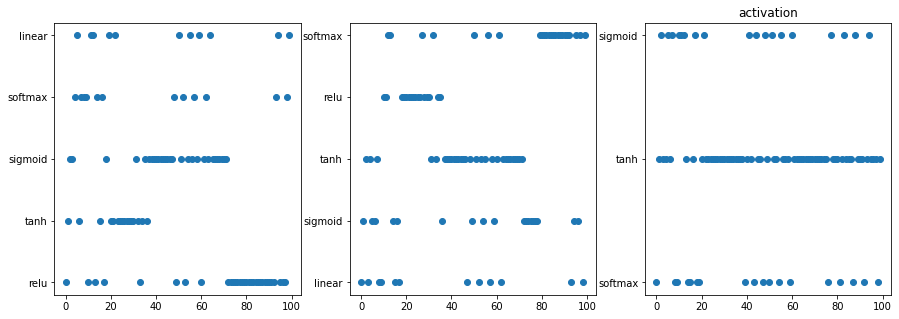

In [ ]:
fig, axs = plt.subplots(1, 3, figsize = (15, 5))
axs[0].scatter(tpe_results['iteration'], tpe_results['activation_1'])
axs[1].scatter(tpe_results['iteration'], tpe_results['activation_2'])
axs[2].scatter(tpe_results['iteration'], tpe_results['activation_out'])
plt.title('activation')

Text(0.5, 1.0, 'layers')

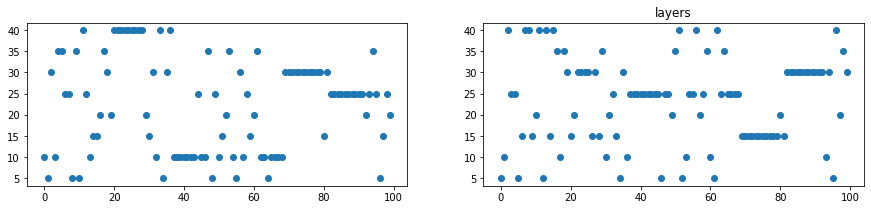

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (15, 3))
axs[0].scatter(tpe_results['iteration'], tpe_results['layers_1'])
axs[1].scatter(tpe_results['iteration'], tpe_results['layers_2'])
plt.title('layers')

Text(0.5, 1.0, 'Other')

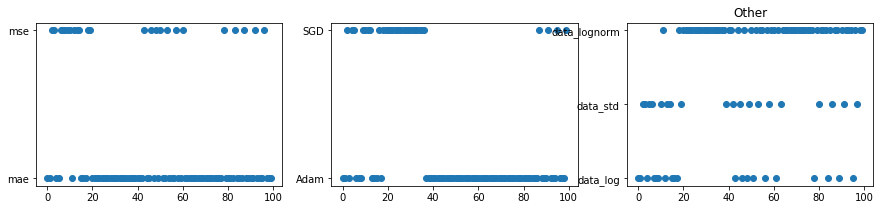

In [ ]:
fig, axs = plt.subplots(1, 3, figsize = (15, 3))
axs[0].scatter(tpe_results['iteration'], tpe_results['loss'])
axs[1].scatter(tpe_results['iteration'], tpe_results['optimizer'])
axs[2].scatter(tpe_results['iteration'], tpe_results['process'])
plt.title('Other')

Теперь давайте обучим несколько моделей нейросетей. Выберем лучшие из предложенных алгаритмом и несколько полученных ранее

In [80]:
df = pd.read_csv('../dataset_csv/mosfet_noise_5.csv')

In [81]:
data = ProcessDataLogNorm(df)

In [ ]:
top_results[:3]

,val_loss,iteration,activation_1,activation_2,activation_out,layers_1,layers_2,loss,optimizer,process
82,1.045662e-08,82,relu,softmax,tanh,25,30,mae,Adam,data_lognorm
72,1.046065e-08,72,relu,sigmoid,tanh,30,15,mae,Adam,data_lognorm
90,1.046205e-08,90,relu,softmax,tanh,25,30,mae,Adam,data_lognorm


Модель 1. Первое место

In [83]:
model_1 = tf.keras.Sequential()

model_1.add(keras.layers.Dense(25, activation='relu', input_shape=(5,)))
model_1.add(keras.layers.Dense(30, activation='softmax'))
model_1.add(keras.layers.Dense(1, activation='tanh'))

model_1.compile(optimizer='adam', loss='mae', metrics=['mse'])
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 25)                150       
                                                                 
 dense_1 (Dense)             (None, 30)                780       
                                                                 
 dense_2 (Dense)             (None, 1)                 31        
                                                                 
Total params: 961
Trainable params: 961
Non-trainable params: 0
_________________________________________________________________


In [84]:
t1 = time.perf_counter()

history_1 = model_1.fit(data.X_train, data.y_train, 
                      epochs=2000, 
                      validation_data=(data.X_test, data.y_test),
                      batch_size=128,
                      shuffle=True,
                      # validation_freq=2,
                      )

print('time taken to run:',time.perf_counter()-t1)

Epoch 1/2000
143/143 [==============================] - 1s 2ms/step - loss: 0.7506 - mse: 0.9195 - val_loss: 0.6508 - val_mse: 0.7421
Epoch 2/2000
143/143 [==============================] - 0s 2ms/step - loss: 0.5210 - mse: 0.5255 - val_loss: 0.4059 - val_mse: 0.3597
Epoch 3/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.3619 - mse: 0.3038 - val_loss: 0.3281 - val_mse: 0.2571
Epoch 4/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.3121 - mse: 0.2403 - val_loss: 0.2962 - val_mse: 0.2190
Epoch 5/2000
143/143 [==============================] - 0s 2ms/step - loss: 0.2873 - mse: 0.2121 - val_loss: 0.2760 - val_mse: 0.1982
Epoch 6/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.2700 - mse: 0.1949 - val_loss: 0.2611 - val_mse: 0.1841
Epoch 7/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.2573 - mse: 0.1828 - val_loss: 0.2512 - val_mse: 0.1747
Epoch 8/2000
143/143 [==============================] - 0s 1ms

Epoch 62/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1823 - mse: 0.1287 - val_loss: 0.1793 - val_mse: 0.1253
Epoch 63/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1823 - mse: 0.1287 - val_loss: 0.1786 - val_mse: 0.1252
Epoch 64/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1821 - mse: 0.1286 - val_loss: 0.1789 - val_mse: 0.1253
Epoch 65/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1821 - mse: 0.1286 - val_loss: 0.1788 - val_mse: 0.1252
Epoch 66/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1820 - mse: 0.1286 - val_loss: 0.1789 - val_mse: 0.1252
Epoch 67/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1819 - mse: 0.1285 - val_loss: 0.1787 - val_mse: 0.1251
Epoch 68/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1818 - mse: 0.1285 - val_loss: 0.1786 - val_mse: 0.1251
Epoch 69/2000
143/143 [==============================] 

143/143 [==============================] - 0s 1ms/step - loss: 0.1795 - mse: 0.1277 - val_loss: 0.1766 - val_mse: 0.1244
Epoch 183/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1794 - mse: 0.1277 - val_loss: 0.1762 - val_mse: 0.1243
Epoch 184/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1795 - mse: 0.1277 - val_loss: 0.1764 - val_mse: 0.1243
Epoch 185/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1794 - mse: 0.1277 - val_loss: 0.1764 - val_mse: 0.1244
Epoch 186/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1794 - mse: 0.1277 - val_loss: 0.1762 - val_mse: 0.1243
Epoch 187/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1794 - mse: 0.1277 - val_loss: 0.1761 - val_mse: 0.1243
Epoch 188/2000
143/143 [==============================] - 0s 2ms/step - loss: 0.1795 - mse: 0.1277 - val_loss: 0.1763 - val_mse: 0.1243
Epoch 189/2000
143/143 [==============================] - 0s 1m

143/143 [==============================] - 0s 1ms/step - loss: 0.1790 - mse: 0.1276 - val_loss: 0.1758 - val_mse: 0.1243
Epoch 303/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1790 - mse: 0.1276 - val_loss: 0.1759 - val_mse: 0.1242
Epoch 304/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1789 - mse: 0.1276 - val_loss: 0.1758 - val_mse: 0.1242
Epoch 305/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1789 - mse: 0.1276 - val_loss: 0.1760 - val_mse: 0.1243
Epoch 306/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1789 - mse: 0.1276 - val_loss: 0.1759 - val_mse: 0.1242
Epoch 307/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1789 - mse: 0.1276 - val_loss: 0.1760 - val_mse: 0.1242
Epoch 308/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1789 - mse: 0.1276 - val_loss: 0.1760 - val_mse: 0.1242
Epoch 309/2000
143/143 [==============================] - 0s 1m

143/143 [==============================] - 0s 1ms/step - loss: 0.1787 - mse: 0.1276 - val_loss: 0.1757 - val_mse: 0.1242
Epoch 423/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1787 - mse: 0.1276 - val_loss: 0.1755 - val_mse: 0.1242
Epoch 424/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1787 - mse: 0.1276 - val_loss: 0.1755 - val_mse: 0.1242
Epoch 425/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1788 - mse: 0.1276 - val_loss: 0.1757 - val_mse: 0.1242
Epoch 426/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1788 - mse: 0.1276 - val_loss: 0.1762 - val_mse: 0.1242
Epoch 427/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1788 - mse: 0.1276 - val_loss: 0.1758 - val_mse: 0.1242
Epoch 428/2000
143/143 [==============================] - 0s 2ms/step - loss: 0.1787 - mse: 0.1276 - val_loss: 0.1754 - val_mse: 0.1242
Epoch 429/2000
143/143 [==============================] - 0s 2m

143/143 [==============================] - 0s 1ms/step - loss: 0.1786 - mse: 0.1276 - val_loss: 0.1756 - val_mse: 0.1242
Epoch 543/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1786 - mse: 0.1276 - val_loss: 0.1757 - val_mse: 0.1242
Epoch 544/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1786 - mse: 0.1276 - val_loss: 0.1752 - val_mse: 0.1242
Epoch 545/2000
143/143 [==============================] - 0s 2ms/step - loss: 0.1786 - mse: 0.1276 - val_loss: 0.1754 - val_mse: 0.1242
Epoch 546/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1785 - mse: 0.1276 - val_loss: 0.1754 - val_mse: 0.1242
Epoch 547/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1785 - mse: 0.1276 - val_loss: 0.1756 - val_mse: 0.1242
Epoch 548/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1786 - mse: 0.1276 - val_loss: 0.1755 - val_mse: 0.1242
Epoch 549/2000
143/143 [==============================] - 0s 1m

143/143 [==============================] - 0s 1ms/step - loss: 0.1784 - mse: 0.1276 - val_loss: 0.1754 - val_mse: 0.1242
Epoch 663/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1785 - mse: 0.1276 - val_loss: 0.1753 - val_mse: 0.1242
Epoch 664/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1785 - mse: 0.1276 - val_loss: 0.1754 - val_mse: 0.1242
Epoch 665/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1784 - mse: 0.1276 - val_loss: 0.1755 - val_mse: 0.1242
Epoch 666/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1785 - mse: 0.1276 - val_loss: 0.1754 - val_mse: 0.1242
Epoch 667/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1784 - mse: 0.1276 - val_loss: 0.1755 - val_mse: 0.1242
Epoch 668/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1785 - mse: 0.1276 - val_loss: 0.1752 - val_mse: 0.1242
Epoch 669/2000
143/143 [==============================] - 0s 1m

143/143 [==============================] - 0s 1ms/step - loss: 0.1784 - mse: 0.1276 - val_loss: 0.1753 - val_mse: 0.1242
Epoch 783/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1783 - mse: 0.1276 - val_loss: 0.1752 - val_mse: 0.1242
Epoch 784/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1784 - mse: 0.1276 - val_loss: 0.1755 - val_mse: 0.1242
Epoch 785/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1785 - mse: 0.1276 - val_loss: 0.1759 - val_mse: 0.1242
Epoch 786/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1784 - mse: 0.1276 - val_loss: 0.1753 - val_mse: 0.1242
Epoch 787/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1784 - mse: 0.1276 - val_loss: 0.1753 - val_mse: 0.1242
Epoch 788/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1783 - mse: 0.1276 - val_loss: 0.1752 - val_mse: 0.1242
Epoch 789/2000
143/143 [==============================] - 0s 1m

143/143 [==============================] - 0s 1ms/step - loss: 0.1782 - mse: 0.1276 - val_loss: 0.1754 - val_mse: 0.1242
Epoch 903/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1783 - mse: 0.1276 - val_loss: 0.1754 - val_mse: 0.1242
Epoch 904/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1783 - mse: 0.1276 - val_loss: 0.1753 - val_mse: 0.1242
Epoch 905/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1783 - mse: 0.1276 - val_loss: 0.1753 - val_mse: 0.1242
Epoch 906/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1782 - mse: 0.1275 - val_loss: 0.1753 - val_mse: 0.1242
Epoch 907/2000
143/143 [==============================] - 0s 2ms/step - loss: 0.1782 - mse: 0.1276 - val_loss: 0.1752 - val_mse: 0.1241
Epoch 908/2000
143/143 [==============================] - 0s 2ms/step - loss: 0.1783 - mse: 0.1276 - val_loss: 0.1752 - val_mse: 0.1242
Epoch 909/2000
143/143 [==============================] - 0s 2m

143/143 [==============================] - 0s 1ms/step - loss: 0.1782 - mse: 0.1276 - val_loss: 0.1751 - val_mse: 0.1242
Epoch 1023/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1782 - mse: 0.1275 - val_loss: 0.1752 - val_mse: 0.1242
Epoch 1024/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1782 - mse: 0.1276 - val_loss: 0.1753 - val_mse: 0.1242
Epoch 1025/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1781 - mse: 0.1275 - val_loss: 0.1753 - val_mse: 0.1242
Epoch 1026/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1782 - mse: 0.1275 - val_loss: 0.1753 - val_mse: 0.1242
Epoch 1027/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1782 - mse: 0.1276 - val_loss: 0.1751 - val_mse: 0.1242
Epoch 1028/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1782 - mse: 0.1275 - val_loss: 0.1752 - val_mse: 0.1242
Epoch 1029/2000
143/143 [==============================] 

Epoch 1082/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1782 - mse: 0.1275 - val_loss: 0.1752 - val_mse: 0.1242
Epoch 1083/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1783 - mse: 0.1276 - val_loss: 0.1751 - val_mse: 0.1242
Epoch 1084/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1781 - mse: 0.1275 - val_loss: 0.1751 - val_mse: 0.1242
Epoch 1085/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1781 - mse: 0.1275 - val_loss: 0.1752 - val_mse: 0.1242
Epoch 1086/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1781 - mse: 0.1275 - val_loss: 0.1755 - val_mse: 0.1242
Epoch 1087/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1782 - mse: 0.1276 - val_loss: 0.1751 - val_mse: 0.1242
Epoch 1088/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1781 - mse: 0.1275 - val_loss: 0.1755 - val_mse: 0.1242
Epoch 1089/2000
143/143 [================

Epoch 1142/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1781 - mse: 0.1275 - val_loss: 0.1750 - val_mse: 0.1241
Epoch 1143/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1781 - mse: 0.1275 - val_loss: 0.1749 - val_mse: 0.1241
Epoch 1144/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1781 - mse: 0.1275 - val_loss: 0.1750 - val_mse: 0.1242
Epoch 1145/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1782 - mse: 0.1275 - val_loss: 0.1753 - val_mse: 0.1242
Epoch 1146/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1781 - mse: 0.1275 - val_loss: 0.1752 - val_mse: 0.1241
Epoch 1147/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1781 - mse: 0.1275 - val_loss: 0.1753 - val_mse: 0.1242
Epoch 1148/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1782 - mse: 0.1275 - val_loss: 0.1750 - val_mse: 0.1241
Epoch 1149/2000
143/143 [================

Epoch 1202/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1781 - mse: 0.1275 - val_loss: 0.1752 - val_mse: 0.1241
Epoch 1203/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1781 - mse: 0.1275 - val_loss: 0.1752 - val_mse: 0.1242
Epoch 1204/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1781 - mse: 0.1275 - val_loss: 0.1752 - val_mse: 0.1242
Epoch 1205/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1781 - mse: 0.1275 - val_loss: 0.1753 - val_mse: 0.1242
Epoch 1206/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1781 - mse: 0.1275 - val_loss: 0.1754 - val_mse: 0.1242
Epoch 1207/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1781 - mse: 0.1275 - val_loss: 0.1751 - val_mse: 0.1242
Epoch 1208/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1781 - mse: 0.1275 - val_loss: 0.1754 - val_mse: 0.1242
Epoch 1209/2000
143/143 [================

Epoch 1262/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1781 - mse: 0.1275 - val_loss: 0.1751 - val_mse: 0.1241
Epoch 1263/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1780 - mse: 0.1275 - val_loss: 0.1750 - val_mse: 0.1241
Epoch 1264/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1780 - mse: 0.1275 - val_loss: 0.1751 - val_mse: 0.1242
Epoch 1265/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1781 - mse: 0.1275 - val_loss: 0.1751 - val_mse: 0.1242
Epoch 1266/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1780 - mse: 0.1275 - val_loss: 0.1752 - val_mse: 0.1242
Epoch 1267/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1782 - mse: 0.1275 - val_loss: 0.1753 - val_mse: 0.1242
Epoch 1268/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1781 - mse: 0.1275 - val_loss: 0.1751 - val_mse: 0.1242
Epoch 1269/2000
143/143 [================

Epoch 1322/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1780 - mse: 0.1275 - val_loss: 0.1750 - val_mse: 0.1241
Epoch 1323/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1781 - mse: 0.1275 - val_loss: 0.1750 - val_mse: 0.1242
Epoch 1324/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1780 - mse: 0.1275 - val_loss: 0.1751 - val_mse: 0.1241
Epoch 1325/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1780 - mse: 0.1275 - val_loss: 0.1749 - val_mse: 0.1241
Epoch 1326/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1780 - mse: 0.1275 - val_loss: 0.1752 - val_mse: 0.1242
Epoch 1327/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1781 - mse: 0.1275 - val_loss: 0.1750 - val_mse: 0.1241
Epoch 1328/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1781 - mse: 0.1275 - val_loss: 0.1752 - val_mse: 0.1241
Epoch 1329/2000
143/143 [================

Epoch 1382/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1781 - mse: 0.1275 - val_loss: 0.1750 - val_mse: 0.1241
Epoch 1383/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1780 - mse: 0.1275 - val_loss: 0.1750 - val_mse: 0.1241
Epoch 1384/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1781 - mse: 0.1275 - val_loss: 0.1757 - val_mse: 0.1242
Epoch 1385/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1780 - mse: 0.1275 - val_loss: 0.1751 - val_mse: 0.1242
Epoch 1386/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1780 - mse: 0.1275 - val_loss: 0.1753 - val_mse: 0.1242
Epoch 1387/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1780 - mse: 0.1275 - val_loss: 0.1751 - val_mse: 0.1241
Epoch 1388/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1780 - mse: 0.1275 - val_loss: 0.1750 - val_mse: 0.1241
Epoch 1389/2000
143/143 [================

Epoch 1442/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1780 - mse: 0.1275 - val_loss: 0.1753 - val_mse: 0.1241
Epoch 1443/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1780 - mse: 0.1275 - val_loss: 0.1758 - val_mse: 0.1242
Epoch 1444/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1780 - mse: 0.1275 - val_loss: 0.1751 - val_mse: 0.1241
Epoch 1445/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1780 - mse: 0.1275 - val_loss: 0.1751 - val_mse: 0.1242
Epoch 1446/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1780 - mse: 0.1275 - val_loss: 0.1752 - val_mse: 0.1242
Epoch 1447/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1780 - mse: 0.1275 - val_loss: 0.1750 - val_mse: 0.1241
Epoch 1448/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1780 - mse: 0.1275 - val_loss: 0.1752 - val_mse: 0.1241
Epoch 1449/2000
143/143 [================

Epoch 1502/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1780 - mse: 0.1275 - val_loss: 0.1751 - val_mse: 0.1241
Epoch 1503/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1780 - mse: 0.1275 - val_loss: 0.1752 - val_mse: 0.1241
Epoch 1504/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1780 - mse: 0.1275 - val_loss: 0.1753 - val_mse: 0.1242
Epoch 1505/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1780 - mse: 0.1275 - val_loss: 0.1750 - val_mse: 0.1241
Epoch 1506/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1780 - mse: 0.1275 - val_loss: 0.1752 - val_mse: 0.1241
Epoch 1507/2000
143/143 [==============================] - 0s 2ms/step - loss: 0.1780 - mse: 0.1275 - val_loss: 0.1749 - val_mse: 0.1241
Epoch 1508/2000
143/143 [==============================] - 0s 2ms/step - loss: 0.1780 - mse: 0.1275 - val_loss: 0.1749 - val_mse: 0.1241
Epoch 1509/2000
143/143 [================

Epoch 1562/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1779 - mse: 0.1275 - val_loss: 0.1752 - val_mse: 0.1242
Epoch 1563/2000
143/143 [==============================] - 0s 2ms/step - loss: 0.1780 - mse: 0.1275 - val_loss: 0.1750 - val_mse: 0.1242
Epoch 1564/2000
143/143 [==============================] - 0s 2ms/step - loss: 0.1780 - mse: 0.1275 - val_loss: 0.1750 - val_mse: 0.1241
Epoch 1565/2000
143/143 [==============================] - 0s 2ms/step - loss: 0.1780 - mse: 0.1275 - val_loss: 0.1750 - val_mse: 0.1242
Epoch 1566/2000
143/143 [==============================] - 0s 2ms/step - loss: 0.1780 - mse: 0.1275 - val_loss: 0.1751 - val_mse: 0.1241
Epoch 1567/2000
143/143 [==============================] - 0s 2ms/step - loss: 0.1780 - mse: 0.1275 - val_loss: 0.1751 - val_mse: 0.1242
Epoch 1568/2000
143/143 [==============================] - 0s 2ms/step - loss: 0.1780 - mse: 0.1275 - val_loss: 0.1749 - val_mse: 0.1241
Epoch 1569/2000
143/143 [================

Epoch 1622/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1780 - mse: 0.1275 - val_loss: 0.1750 - val_mse: 0.1241
Epoch 1623/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1779 - mse: 0.1275 - val_loss: 0.1751 - val_mse: 0.1241
Epoch 1624/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1780 - mse: 0.1275 - val_loss: 0.1749 - val_mse: 0.1241
Epoch 1625/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1780 - mse: 0.1275 - val_loss: 0.1753 - val_mse: 0.1242
Epoch 1626/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1779 - mse: 0.1275 - val_loss: 0.1750 - val_mse: 0.1241
Epoch 1627/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1779 - mse: 0.1275 - val_loss: 0.1748 - val_mse: 0.1241
Epoch 1628/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1779 - mse: 0.1275 - val_loss: 0.1751 - val_mse: 0.1242
Epoch 1629/2000
143/143 [================

Epoch 1682/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1780 - mse: 0.1275 - val_loss: 0.1750 - val_mse: 0.1241
Epoch 1683/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1779 - mse: 0.1275 - val_loss: 0.1751 - val_mse: 0.1242
Epoch 1684/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1780 - mse: 0.1275 - val_loss: 0.1749 - val_mse: 0.1241
Epoch 1685/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1780 - mse: 0.1275 - val_loss: 0.1749 - val_mse: 0.1241
Epoch 1686/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1779 - mse: 0.1275 - val_loss: 0.1751 - val_mse: 0.1241
Epoch 1687/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1779 - mse: 0.1275 - val_loss: 0.1750 - val_mse: 0.1242
Epoch 1688/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1780 - mse: 0.1275 - val_loss: 0.1751 - val_mse: 0.1241
Epoch 1689/2000
143/143 [================

Epoch 1742/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1780 - mse: 0.1275 - val_loss: 0.1750 - val_mse: 0.1241
Epoch 1743/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1779 - mse: 0.1275 - val_loss: 0.1753 - val_mse: 0.1242
Epoch 1744/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1779 - mse: 0.1275 - val_loss: 0.1750 - val_mse: 0.1241
Epoch 1745/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1779 - mse: 0.1275 - val_loss: 0.1751 - val_mse: 0.1241
Epoch 1746/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1779 - mse: 0.1275 - val_loss: 0.1749 - val_mse: 0.1241
Epoch 1747/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1779 - mse: 0.1275 - val_loss: 0.1751 - val_mse: 0.1242
Epoch 1748/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1780 - mse: 0.1275 - val_loss: 0.1750 - val_mse: 0.1241
Epoch 1749/2000
143/143 [================

Epoch 1802/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1779 - mse: 0.1275 - val_loss: 0.1748 - val_mse: 0.1241
Epoch 1803/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1780 - mse: 0.1275 - val_loss: 0.1753 - val_mse: 0.1242
Epoch 1804/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1779 - mse: 0.1275 - val_loss: 0.1750 - val_mse: 0.1241
Epoch 1805/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1779 - mse: 0.1275 - val_loss: 0.1756 - val_mse: 0.1242
Epoch 1806/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1779 - mse: 0.1275 - val_loss: 0.1750 - val_mse: 0.1242
Epoch 1807/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1779 - mse: 0.1275 - val_loss: 0.1749 - val_mse: 0.1242
Epoch 1808/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1779 - mse: 0.1275 - val_loss: 0.1750 - val_mse: 0.1241
Epoch 1809/2000
143/143 [================

Epoch 1862/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1779 - mse: 0.1275 - val_loss: 0.1748 - val_mse: 0.1241
Epoch 1863/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1778 - mse: 0.1275 - val_loss: 0.1749 - val_mse: 0.1241
Epoch 1864/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1779 - mse: 0.1275 - val_loss: 0.1752 - val_mse: 0.1241
Epoch 1865/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1780 - mse: 0.1275 - val_loss: 0.1748 - val_mse: 0.1241
Epoch 1866/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1779 - mse: 0.1275 - val_loss: 0.1752 - val_mse: 0.1241
Epoch 1867/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1779 - mse: 0.1275 - val_loss: 0.1749 - val_mse: 0.1241
Epoch 1868/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1779 - mse: 0.1275 - val_loss: 0.1749 - val_mse: 0.1241
Epoch 1869/2000
143/143 [================

Epoch 1922/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1779 - mse: 0.1275 - val_loss: 0.1749 - val_mse: 0.1241
Epoch 1923/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1779 - mse: 0.1275 - val_loss: 0.1748 - val_mse: 0.1241
Epoch 1924/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1778 - mse: 0.1275 - val_loss: 0.1751 - val_mse: 0.1242
Epoch 1925/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1779 - mse: 0.1275 - val_loss: 0.1750 - val_mse: 0.1241
Epoch 1926/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1779 - mse: 0.1275 - val_loss: 0.1748 - val_mse: 0.1241
Epoch 1927/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1779 - mse: 0.1275 - val_loss: 0.1749 - val_mse: 0.1241
Epoch 1928/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1779 - mse: 0.1275 - val_loss: 0.1751 - val_mse: 0.1241
Epoch 1929/2000
143/143 [================

Epoch 1982/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1779 - mse: 0.1275 - val_loss: 0.1748 - val_mse: 0.1241
Epoch 1983/2000
143/143 [==============================] - 0s 2ms/step - loss: 0.1778 - mse: 0.1275 - val_loss: 0.1750 - val_mse: 0.1241
Epoch 1984/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1779 - mse: 0.1275 - val_loss: 0.1749 - val_mse: 0.1241
Epoch 1985/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1779 - mse: 0.1275 - val_loss: 0.1751 - val_mse: 0.1241
Epoch 1986/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1779 - mse: 0.1275 - val_loss: 0.1753 - val_mse: 0.1242
Epoch 1987/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1779 - mse: 0.1275 - val_loss: 0.1750 - val_mse: 0.1241
Epoch 1988/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1779 - mse: 0.1275 - val_loss: 0.1749 - val_mse: 0.1241
Epoch 1989/2000
143/143 [================

Модель 2. Второе место

In [ ]:
top_results[:3]

,val_loss,iteration,activation_1,activation_2,activation_out,layers_1,layers_2,loss,optimizer,process
82,1.045662e-08,82,relu,softmax,tanh,25,30,mae,Adam,data_lognorm
72,1.046065e-08,72,relu,sigmoid,tanh,30,15,mae,Adam,data_lognorm
90,1.046205e-08,90,relu,softmax,tanh,25,30,mae,Adam,data_lognorm


In [85]:
model_2 = tf.keras.Sequential()

model_2.add(keras.layers.Dense(30, activation='relu', input_shape=(5,)))
model_2.add(keras.layers.Dense(15, activation='sigmoid'))
model_2.add(keras.layers.Dense(1, activation='tanh'))

model_2.compile(optimizer='adam', loss='mae', metrics=['mse'])
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 30)                180       
                                                                 
 dense_4 (Dense)             (None, 15)                465       
                                                                 
 dense_5 (Dense)             (None, 1)                 16        
                                                                 
Total params: 661
Trainable params: 661
Non-trainable params: 0
_________________________________________________________________


In [86]:
t1 = time.perf_counter()

history_2 = model_2.fit(data.X_train, data.y_train, 
                      epochs=2000, 
                      validation_data=(data.X_test, data.y_test),
                      batch_size=128,
                      shuffle=True,
                      # validation_freq=2,
                      )

print('time taken to run:',time.perf_counter()-t1)

Epoch 1/2000
143/143 [==============================] - 1s 2ms/step - loss: 0.6959 - mse: 0.7427 - val_loss: 0.4646 - val_mse: 0.3903
Epoch 2/2000
143/143 [==============================] - 0s 2ms/step - loss: 0.3378 - mse: 0.2408 - val_loss: 0.2547 - val_mse: 0.1629
Epoch 3/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.2414 - mse: 0.1544 - val_loss: 0.2306 - val_mse: 0.1461
Epoch 4/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.2279 - mse: 0.1463 - val_loss: 0.2229 - val_mse: 0.1418
Epoch 5/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.2231 - mse: 0.1433 - val_loss: 0.2190 - val_mse: 0.1393
Epoch 6/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.2208 - mse: 0.1416 - val_loss: 0.2174 - val_mse: 0.1378
Epoch 7/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.2188 - mse: 0.1405 - val_loss: 0.2158 - val_mse: 0.1370
Epoch 8/2000
143/143 [==============================] - 0s 2ms

Epoch 62/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1865 - mse: 0.1287 - val_loss: 0.1829 - val_mse: 0.1253
Epoch 63/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1867 - mse: 0.1287 - val_loss: 0.1850 - val_mse: 0.1254
Epoch 64/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1863 - mse: 0.1287 - val_loss: 0.1830 - val_mse: 0.1253
Epoch 65/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1865 - mse: 0.1287 - val_loss: 0.1852 - val_mse: 0.1254
Epoch 66/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1864 - mse: 0.1287 - val_loss: 0.1830 - val_mse: 0.1253
Epoch 67/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1864 - mse: 0.1287 - val_loss: 0.1831 - val_mse: 0.1253
Epoch 68/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1861 - mse: 0.1286 - val_loss: 0.1828 - val_mse: 0.1253
Epoch 69/2000
143/143 [==============================] 

143/143 [==============================] - 0s 2ms/step - loss: 0.1829 - mse: 0.1281 - val_loss: 0.1786 - val_mse: 0.1246
Epoch 183/2000
143/143 [==============================] - 0s 2ms/step - loss: 0.1824 - mse: 0.1281 - val_loss: 0.1790 - val_mse: 0.1246
Epoch 184/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1825 - mse: 0.1281 - val_loss: 0.1787 - val_mse: 0.1246
Epoch 185/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1823 - mse: 0.1280 - val_loss: 0.1785 - val_mse: 0.1246
Epoch 186/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1824 - mse: 0.1280 - val_loss: 0.1789 - val_mse: 0.1246
Epoch 187/2000
143/143 [==============================] - 0s 2ms/step - loss: 0.1822 - mse: 0.1280 - val_loss: 0.1788 - val_mse: 0.1246
Epoch 188/2000
143/143 [==============================] - 0s 2ms/step - loss: 0.1823 - mse: 0.1280 - val_loss: 0.1786 - val_mse: 0.1246
Epoch 189/2000
143/143 [==============================] - 0s 1m

143/143 [==============================] - 0s 1ms/step - loss: 0.1814 - mse: 0.1279 - val_loss: 0.1795 - val_mse: 0.1246
Epoch 303/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1813 - mse: 0.1279 - val_loss: 0.1780 - val_mse: 0.1245
Epoch 304/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1815 - mse: 0.1279 - val_loss: 0.1780 - val_mse: 0.1245
Epoch 305/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1813 - mse: 0.1279 - val_loss: 0.1779 - val_mse: 0.1245
Epoch 306/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1814 - mse: 0.1279 - val_loss: 0.1807 - val_mse: 0.1247
Epoch 307/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1815 - mse: 0.1279 - val_loss: 0.1784 - val_mse: 0.1245
Epoch 308/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1814 - mse: 0.1279 - val_loss: 0.1781 - val_mse: 0.1245
Epoch 309/2000
143/143 [==============================] - 0s 1m

143/143 [==============================] - 0s 1ms/step - loss: 0.1804 - mse: 0.1277 - val_loss: 0.1771 - val_mse: 0.1244
Epoch 423/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1804 - mse: 0.1277 - val_loss: 0.1770 - val_mse: 0.1243
Epoch 424/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1804 - mse: 0.1277 - val_loss: 0.1778 - val_mse: 0.1244
Epoch 425/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1804 - mse: 0.1277 - val_loss: 0.1776 - val_mse: 0.1244
Epoch 426/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1802 - mse: 0.1277 - val_loss: 0.1766 - val_mse: 0.1243
Epoch 427/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1803 - mse: 0.1277 - val_loss: 0.1771 - val_mse: 0.1243
Epoch 428/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1802 - mse: 0.1277 - val_loss: 0.1768 - val_mse: 0.1243
Epoch 429/2000
143/143 [==============================] - 0s 1m

143/143 [==============================] - 0s 1ms/step - loss: 0.1799 - mse: 0.1277 - val_loss: 0.1763 - val_mse: 0.1243
Epoch 543/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1798 - mse: 0.1277 - val_loss: 0.1764 - val_mse: 0.1243
Epoch 544/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1797 - mse: 0.1277 - val_loss: 0.1765 - val_mse: 0.1243
Epoch 545/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1798 - mse: 0.1277 - val_loss: 0.1765 - val_mse: 0.1243
Epoch 546/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1798 - mse: 0.1277 - val_loss: 0.1773 - val_mse: 0.1243
Epoch 547/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1799 - mse: 0.1277 - val_loss: 0.1764 - val_mse: 0.1243
Epoch 548/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1797 - mse: 0.1277 - val_loss: 0.1764 - val_mse: 0.1243
Epoch 549/2000
143/143 [==============================] - 0s 1m

143/143 [==============================] - 0s 1ms/step - loss: 0.1793 - mse: 0.1276 - val_loss: 0.1763 - val_mse: 0.1242
Epoch 663/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1794 - mse: 0.1276 - val_loss: 0.1762 - val_mse: 0.1242
Epoch 664/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1794 - mse: 0.1276 - val_loss: 0.1761 - val_mse: 0.1243
Epoch 665/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1796 - mse: 0.1277 - val_loss: 0.1765 - val_mse: 0.1242
Epoch 666/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1794 - mse: 0.1276 - val_loss: 0.1758 - val_mse: 0.1242
Epoch 667/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1794 - mse: 0.1276 - val_loss: 0.1761 - val_mse: 0.1242
Epoch 668/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1793 - mse: 0.1276 - val_loss: 0.1760 - val_mse: 0.1242
Epoch 669/2000
143/143 [==============================] - 0s 1m

143/143 [==============================] - 0s 1ms/step - loss: 0.1791 - mse: 0.1276 - val_loss: 0.1758 - val_mse: 0.1242
Epoch 783/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1791 - mse: 0.1276 - val_loss: 0.1757 - val_mse: 0.1242
Epoch 784/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1791 - mse: 0.1276 - val_loss: 0.1754 - val_mse: 0.1242
Epoch 785/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1790 - mse: 0.1276 - val_loss: 0.1758 - val_mse: 0.1242
Epoch 786/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1791 - mse: 0.1276 - val_loss: 0.1762 - val_mse: 0.1243
Epoch 787/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1791 - mse: 0.1276 - val_loss: 0.1762 - val_mse: 0.1242
Epoch 788/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1791 - mse: 0.1276 - val_loss: 0.1754 - val_mse: 0.1242
Epoch 789/2000
143/143 [==============================] - 0s 1m

143/143 [==============================] - 0s 1ms/step - loss: 0.1789 - mse: 0.1276 - val_loss: 0.1767 - val_mse: 0.1242
Epoch 903/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1788 - mse: 0.1276 - val_loss: 0.1753 - val_mse: 0.1242
Epoch 904/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1788 - mse: 0.1276 - val_loss: 0.1754 - val_mse: 0.1242
Epoch 905/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1789 - mse: 0.1276 - val_loss: 0.1758 - val_mse: 0.1242
Epoch 906/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1788 - mse: 0.1276 - val_loss: 0.1763 - val_mse: 0.1242
Epoch 907/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1789 - mse: 0.1276 - val_loss: 0.1757 - val_mse: 0.1242
Epoch 908/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1788 - mse: 0.1276 - val_loss: 0.1754 - val_mse: 0.1242
Epoch 909/2000
143/143 [==============================] - 0s 1m

143/143 [==============================] - 0s 1ms/step - loss: 0.1787 - mse: 0.1276 - val_loss: 0.1758 - val_mse: 0.1242
Epoch 1023/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1791 - mse: 0.1276 - val_loss: 0.1760 - val_mse: 0.1242
Epoch 1024/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1788 - mse: 0.1276 - val_loss: 0.1754 - val_mse: 0.1242
Epoch 1025/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1786 - mse: 0.1276 - val_loss: 0.1753 - val_mse: 0.1242
Epoch 1026/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1787 - mse: 0.1276 - val_loss: 0.1756 - val_mse: 0.1242
Epoch 1027/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1786 - mse: 0.1276 - val_loss: 0.1759 - val_mse: 0.1242
Epoch 1028/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1787 - mse: 0.1276 - val_loss: 0.1753 - val_mse: 0.1242
Epoch 1029/2000
143/143 [==============================] 

Epoch 1082/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1786 - mse: 0.1276 - val_loss: 0.1753 - val_mse: 0.1242
Epoch 1083/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1787 - mse: 0.1276 - val_loss: 0.1765 - val_mse: 0.1242
Epoch 1084/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1788 - mse: 0.1276 - val_loss: 0.1756 - val_mse: 0.1242
Epoch 1085/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1786 - mse: 0.1276 - val_loss: 0.1751 - val_mse: 0.1241
Epoch 1086/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1787 - mse: 0.1276 - val_loss: 0.1764 - val_mse: 0.1242
Epoch 1087/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1788 - mse: 0.1276 - val_loss: 0.1757 - val_mse: 0.1242
Epoch 1088/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1786 - mse: 0.1276 - val_loss: 0.1750 - val_mse: 0.1241
Epoch 1089/2000
143/143 [================

Epoch 1142/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1787 - mse: 0.1276 - val_loss: 0.1753 - val_mse: 0.1242
Epoch 1143/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1787 - mse: 0.1276 - val_loss: 0.1750 - val_mse: 0.1241
Epoch 1144/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1786 - mse: 0.1276 - val_loss: 0.1753 - val_mse: 0.1242
Epoch 1145/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1785 - mse: 0.1276 - val_loss: 0.1757 - val_mse: 0.1242
Epoch 1146/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1786 - mse: 0.1276 - val_loss: 0.1751 - val_mse: 0.1241
Epoch 1147/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1785 - mse: 0.1276 - val_loss: 0.1753 - val_mse: 0.1242
Epoch 1148/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1786 - mse: 0.1276 - val_loss: 0.1756 - val_mse: 0.1242
Epoch 1149/2000
143/143 [================

Epoch 1202/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1786 - mse: 0.1276 - val_loss: 0.1750 - val_mse: 0.1241
Epoch 1203/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1786 - mse: 0.1276 - val_loss: 0.1754 - val_mse: 0.1242
Epoch 1204/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1784 - mse: 0.1276 - val_loss: 0.1760 - val_mse: 0.1242
Epoch 1205/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1784 - mse: 0.1276 - val_loss: 0.1754 - val_mse: 0.1242
Epoch 1206/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1784 - mse: 0.1276 - val_loss: 0.1753 - val_mse: 0.1242
Epoch 1207/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1787 - mse: 0.1276 - val_loss: 0.1762 - val_mse: 0.1242
Epoch 1208/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1785 - mse: 0.1276 - val_loss: 0.1754 - val_mse: 0.1242
Epoch 1209/2000
143/143 [================

Epoch 1262/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1784 - mse: 0.1276 - val_loss: 0.1752 - val_mse: 0.1242
Epoch 1263/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1785 - mse: 0.1276 - val_loss: 0.1753 - val_mse: 0.1241
Epoch 1264/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1784 - mse: 0.1276 - val_loss: 0.1756 - val_mse: 0.1242
Epoch 1265/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1784 - mse: 0.1276 - val_loss: 0.1751 - val_mse: 0.1242
Epoch 1266/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1783 - mse: 0.1275 - val_loss: 0.1752 - val_mse: 0.1241
Epoch 1267/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1784 - mse: 0.1276 - val_loss: 0.1752 - val_mse: 0.1242
Epoch 1268/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1784 - mse: 0.1276 - val_loss: 0.1757 - val_mse: 0.1242
Epoch 1269/2000
143/143 [================

Epoch 1322/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1784 - mse: 0.1276 - val_loss: 0.1752 - val_mse: 0.1241
Epoch 1323/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1784 - mse: 0.1276 - val_loss: 0.1754 - val_mse: 0.1242
Epoch 1324/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1786 - mse: 0.1276 - val_loss: 0.1757 - val_mse: 0.1242
Epoch 1325/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1784 - mse: 0.1276 - val_loss: 0.1758 - val_mse: 0.1242
Epoch 1326/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1784 - mse: 0.1276 - val_loss: 0.1754 - val_mse: 0.1242
Epoch 1327/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1784 - mse: 0.1276 - val_loss: 0.1753 - val_mse: 0.1242
Epoch 1328/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1783 - mse: 0.1276 - val_loss: 0.1750 - val_mse: 0.1241
Epoch 1329/2000
143/143 [================

Epoch 1382/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1783 - mse: 0.1275 - val_loss: 0.1753 - val_mse: 0.1241
Epoch 1383/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1784 - mse: 0.1275 - val_loss: 0.1751 - val_mse: 0.1242
Epoch 1384/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1784 - mse: 0.1276 - val_loss: 0.1754 - val_mse: 0.1241
Epoch 1385/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1785 - mse: 0.1276 - val_loss: 0.1753 - val_mse: 0.1242
Epoch 1386/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1785 - mse: 0.1276 - val_loss: 0.1752 - val_mse: 0.1242
Epoch 1387/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1783 - mse: 0.1275 - val_loss: 0.1750 - val_mse: 0.1241
Epoch 1388/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1784 - mse: 0.1276 - val_loss: 0.1753 - val_mse: 0.1242
Epoch 1389/2000
143/143 [================

Epoch 1442/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1784 - mse: 0.1276 - val_loss: 0.1754 - val_mse: 0.1242
Epoch 1443/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1783 - mse: 0.1275 - val_loss: 0.1751 - val_mse: 0.1241
Epoch 1444/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1783 - mse: 0.1275 - val_loss: 0.1750 - val_mse: 0.1241
Epoch 1445/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1783 - mse: 0.1275 - val_loss: 0.1749 - val_mse: 0.1241
Epoch 1446/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1783 - mse: 0.1275 - val_loss: 0.1757 - val_mse: 0.1242
Epoch 1447/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1783 - mse: 0.1275 - val_loss: 0.1758 - val_mse: 0.1242
Epoch 1448/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1784 - mse: 0.1275 - val_loss: 0.1753 - val_mse: 0.1242
Epoch 1449/2000
143/143 [================

Epoch 1502/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1784 - mse: 0.1276 - val_loss: 0.1756 - val_mse: 0.1242
Epoch 1503/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1783 - mse: 0.1275 - val_loss: 0.1755 - val_mse: 0.1242
Epoch 1504/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1782 - mse: 0.1275 - val_loss: 0.1750 - val_mse: 0.1241
Epoch 1505/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1783 - mse: 0.1275 - val_loss: 0.1754 - val_mse: 0.1241
Epoch 1506/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1784 - mse: 0.1276 - val_loss: 0.1762 - val_mse: 0.1242
Epoch 1507/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1783 - mse: 0.1275 - val_loss: 0.1749 - val_mse: 0.1241
Epoch 1508/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1783 - mse: 0.1275 - val_loss: 0.1751 - val_mse: 0.1242
Epoch 1509/2000
143/143 [================

Epoch 1562/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1782 - mse: 0.1275 - val_loss: 0.1760 - val_mse: 0.1242
Epoch 1563/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1782 - mse: 0.1275 - val_loss: 0.1748 - val_mse: 0.1241
Epoch 1564/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1781 - mse: 0.1275 - val_loss: 0.1750 - val_mse: 0.1241
Epoch 1565/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1783 - mse: 0.1275 - val_loss: 0.1761 - val_mse: 0.1242
Epoch 1566/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1783 - mse: 0.1275 - val_loss: 0.1753 - val_mse: 0.1241
Epoch 1567/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1783 - mse: 0.1275 - val_loss: 0.1751 - val_mse: 0.1241
Epoch 1568/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1783 - mse: 0.1275 - val_loss: 0.1751 - val_mse: 0.1241
Epoch 1569/2000
143/143 [================

Epoch 1622/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1781 - mse: 0.1275 - val_loss: 0.1749 - val_mse: 0.1241
Epoch 1623/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1783 - mse: 0.1275 - val_loss: 0.1749 - val_mse: 0.1241
Epoch 1624/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1782 - mse: 0.1275 - val_loss: 0.1750 - val_mse: 0.1241
Epoch 1625/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1783 - mse: 0.1275 - val_loss: 0.1752 - val_mse: 0.1242
Epoch 1626/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1783 - mse: 0.1275 - val_loss: 0.1748 - val_mse: 0.1241
Epoch 1627/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1783 - mse: 0.1275 - val_loss: 0.1751 - val_mse: 0.1241
Epoch 1628/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1783 - mse: 0.1275 - val_loss: 0.1750 - val_mse: 0.1241
Epoch 1629/2000
143/143 [================

Epoch 1682/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1782 - mse: 0.1275 - val_loss: 0.1762 - val_mse: 0.1242
Epoch 1683/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1783 - mse: 0.1275 - val_loss: 0.1748 - val_mse: 0.1241
Epoch 1684/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1783 - mse: 0.1275 - val_loss: 0.1751 - val_mse: 0.1242
Epoch 1685/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1782 - mse: 0.1275 - val_loss: 0.1752 - val_mse: 0.1241
Epoch 1686/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1782 - mse: 0.1275 - val_loss: 0.1750 - val_mse: 0.1241
Epoch 1687/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1783 - mse: 0.1275 - val_loss: 0.1751 - val_mse: 0.1242
Epoch 1688/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1783 - mse: 0.1275 - val_loss: 0.1749 - val_mse: 0.1241
Epoch 1689/2000
143/143 [================

Epoch 1742/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1781 - mse: 0.1275 - val_loss: 0.1750 - val_mse: 0.1242
Epoch 1743/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1782 - mse: 0.1275 - val_loss: 0.1749 - val_mse: 0.1241
Epoch 1744/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1783 - mse: 0.1275 - val_loss: 0.1749 - val_mse: 0.1241
Epoch 1745/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1782 - mse: 0.1275 - val_loss: 0.1752 - val_mse: 0.1241
Epoch 1746/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1781 - mse: 0.1275 - val_loss: 0.1748 - val_mse: 0.1241
Epoch 1747/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1782 - mse: 0.1275 - val_loss: 0.1752 - val_mse: 0.1242
Epoch 1748/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1781 - mse: 0.1275 - val_loss: 0.1751 - val_mse: 0.1241
Epoch 1749/2000
143/143 [================

Epoch 1802/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1782 - mse: 0.1275 - val_loss: 0.1750 - val_mse: 0.1241
Epoch 1803/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1781 - mse: 0.1275 - val_loss: 0.1752 - val_mse: 0.1241
Epoch 1804/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1781 - mse: 0.1275 - val_loss: 0.1750 - val_mse: 0.1241
Epoch 1805/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1781 - mse: 0.1275 - val_loss: 0.1749 - val_mse: 0.1241
Epoch 1806/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1782 - mse: 0.1275 - val_loss: 0.1751 - val_mse: 0.1242
Epoch 1807/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1781 - mse: 0.1275 - val_loss: 0.1753 - val_mse: 0.1241
Epoch 1808/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1782 - mse: 0.1275 - val_loss: 0.1751 - val_mse: 0.1241
Epoch 1809/2000
143/143 [================

Epoch 1862/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1780 - mse: 0.1275 - val_loss: 0.1752 - val_mse: 0.1241
Epoch 1863/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1781 - mse: 0.1275 - val_loss: 0.1751 - val_mse: 0.1241
Epoch 1864/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1781 - mse: 0.1275 - val_loss: 0.1750 - val_mse: 0.1241
Epoch 1865/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1782 - mse: 0.1275 - val_loss: 0.1751 - val_mse: 0.1242
Epoch 1866/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1781 - mse: 0.1275 - val_loss: 0.1748 - val_mse: 0.1241
Epoch 1867/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1782 - mse: 0.1275 - val_loss: 0.1754 - val_mse: 0.1241
Epoch 1868/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1782 - mse: 0.1275 - val_loss: 0.1748 - val_mse: 0.1241
Epoch 1869/2000
143/143 [================

Epoch 1922/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1780 - mse: 0.1275 - val_loss: 0.1748 - val_mse: 0.1241
Epoch 1923/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1780 - mse: 0.1275 - val_loss: 0.1750 - val_mse: 0.1241
Epoch 1924/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1781 - mse: 0.1275 - val_loss: 0.1756 - val_mse: 0.1242
Epoch 1925/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1782 - mse: 0.1275 - val_loss: 0.1752 - val_mse: 0.1241
Epoch 1926/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1781 - mse: 0.1275 - val_loss: 0.1754 - val_mse: 0.1242
Epoch 1927/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1782 - mse: 0.1275 - val_loss: 0.1765 - val_mse: 0.1242
Epoch 1928/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1782 - mse: 0.1275 - val_loss: 0.1748 - val_mse: 0.1241
Epoch 1929/2000
143/143 [================

Epoch 1982/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1780 - mse: 0.1275 - val_loss: 0.1749 - val_mse: 0.1241
Epoch 1983/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1781 - mse: 0.1275 - val_loss: 0.1752 - val_mse: 0.1241
Epoch 1984/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1782 - mse: 0.1275 - val_loss: 0.1747 - val_mse: 0.1241
Epoch 1985/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1781 - mse: 0.1275 - val_loss: 0.1750 - val_mse: 0.1241
Epoch 1986/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1781 - mse: 0.1275 - val_loss: 0.1750 - val_mse: 0.1241
Epoch 1987/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1780 - mse: 0.1275 - val_loss: 0.1747 - val_mse: 0.1241
Epoch 1988/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1780 - mse: 0.1275 - val_loss: 0.1749 - val_mse: 0.1241
Epoch 1989/2000
143/143 [================

Модель 3. Просто какая-то модель

In [87]:
# We'll use Keras to create a Neural network

# 5 - 32 - 16 - 1

model_3 = tf.keras.Sequential()

model_3.add(keras.layers.Dense(32, activation='tanh', input_shape=(5,)))
model_3.add(keras.layers.Dense(16, activation='tanh'))
model_3.add(keras.layers.Dense(1, activation='tanh'))

model_3.compile(optimizer='adam', loss='mse', metrics=['mse'])
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 32)                192       
                                                                 
 dense_7 (Dense)             (None, 16)                528       
                                                                 
 dense_8 (Dense)             (None, 1)                 17        
                                                                 
Total params: 737
Trainable params: 737
Non-trainable params: 0
_________________________________________________________________


In [88]:
t1 = time.perf_counter()

history_3 = model_3.fit(data.X_train, data.y_train, 
                      epochs=2000, 
                      validation_data=(data.X_test, data.y_test),
                      batch_size=128,
                      shuffle=True,
                      # validation_freq=2,
                      )

print('time taken to run:',time.perf_counter()-t1)

Epoch 1/2000
143/143 [==============================] - 1s 2ms/step - loss: 0.3025 - mse: 0.3025 - val_loss: 0.1745 - val_mse: 0.1745
Epoch 2/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1663 - mse: 0.1663 - val_loss: 0.1573 - val_mse: 0.1573
Epoch 3/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1562 - mse: 0.1562 - val_loss: 0.1499 - val_mse: 0.1499
Epoch 4/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1500 - mse: 0.1500 - val_loss: 0.1449 - val_mse: 0.1449
Epoch 5/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1459 - mse: 0.1459 - val_loss: 0.1412 - val_mse: 0.1412
Epoch 6/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1427 - mse: 0.1427 - val_loss: 0.1383 - val_mse: 0.1383
Epoch 7/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1402 - mse: 0.1402 - val_loss: 0.1361 - val_mse: 0.1361
Epoch 8/2000
143/143 [==============================] - 0s 1ms

Epoch 62/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1280 - mse: 0.1280 - val_loss: 0.1247 - val_mse: 0.1247
Epoch 63/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1280 - mse: 0.1280 - val_loss: 0.1245 - val_mse: 0.1245
Epoch 64/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1279 - mse: 0.1279 - val_loss: 0.1245 - val_mse: 0.1245
Epoch 65/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1280 - mse: 0.1280 - val_loss: 0.1246 - val_mse: 0.1246
Epoch 66/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1279 - mse: 0.1279 - val_loss: 0.1246 - val_mse: 0.1246
Epoch 67/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1279 - mse: 0.1279 - val_loss: 0.1245 - val_mse: 0.1245
Epoch 68/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1279 - mse: 0.1279 - val_loss: 0.1246 - val_mse: 0.1246
Epoch 69/2000
143/143 [==============================] 

143/143 [==============================] - 0s 1ms/step - loss: 0.1276 - mse: 0.1276 - val_loss: 0.1242 - val_mse: 0.1242
Epoch 183/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1276 - mse: 0.1276 - val_loss: 0.1242 - val_mse: 0.1242
Epoch 184/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1276 - mse: 0.1276 - val_loss: 0.1243 - val_mse: 0.1243
Epoch 185/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1276 - mse: 0.1276 - val_loss: 0.1242 - val_mse: 0.1242
Epoch 186/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1276 - mse: 0.1276 - val_loss: 0.1243 - val_mse: 0.1243
Epoch 187/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1276 - mse: 0.1276 - val_loss: 0.1243 - val_mse: 0.1243
Epoch 188/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1276 - mse: 0.1276 - val_loss: 0.1242 - val_mse: 0.1242
Epoch 189/2000
143/143 [==============================] - 0s 1m

143/143 [==============================] - 0s 1ms/step - loss: 0.1276 - mse: 0.1276 - val_loss: 0.1242 - val_mse: 0.1242
Epoch 303/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1276 - mse: 0.1276 - val_loss: 0.1242 - val_mse: 0.1242
Epoch 304/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1276 - mse: 0.1276 - val_loss: 0.1242 - val_mse: 0.1242
Epoch 305/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1276 - mse: 0.1276 - val_loss: 0.1242 - val_mse: 0.1242
Epoch 306/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1276 - mse: 0.1276 - val_loss: 0.1242 - val_mse: 0.1242
Epoch 307/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1276 - mse: 0.1276 - val_loss: 0.1242 - val_mse: 0.1242
Epoch 308/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1276 - mse: 0.1276 - val_loss: 0.1242 - val_mse: 0.1242
Epoch 309/2000
143/143 [==============================] - 0s 1m

143/143 [==============================] - 0s 1ms/step - loss: 0.1276 - mse: 0.1276 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 423/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1276 - mse: 0.1276 - val_loss: 0.1242 - val_mse: 0.1242
Epoch 424/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1276 - mse: 0.1276 - val_loss: 0.1242 - val_mse: 0.1242
Epoch 425/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1276 - mse: 0.1276 - val_loss: 0.1242 - val_mse: 0.1242
Epoch 426/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1276 - mse: 0.1276 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 427/2000
143/143 [==============================] - 0s 2ms/step - loss: 0.1276 - mse: 0.1276 - val_loss: 0.1242 - val_mse: 0.1242
Epoch 428/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1276 - mse: 0.1276 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 429/2000
143/143 [==============================] - 0s 1m

143/143 [==============================] - 0s 2ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1242 - val_mse: 0.1242
Epoch 543/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 544/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1276 - mse: 0.1276 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 545/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 546/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 547/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 548/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 549/2000
143/143 [==============================] - 0s 2m

143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 663/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1242 - val_mse: 0.1242
Epoch 664/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 665/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 666/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1242 - val_mse: 0.1242
Epoch 667/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 668/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 669/2000
143/143 [==============================] - 0s 1m

143/143 [==============================] - 0s 2ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 783/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 784/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 785/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 786/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 787/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1242 - val_mse: 0.1242
Epoch 788/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 789/2000
143/143 [==============================] - 0s 1m

143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 903/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 904/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 905/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 906/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1242 - val_mse: 0.1242
Epoch 907/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 908/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1242 - val_mse: 0.1242
Epoch 909/2000
143/143 [==============================] - 0s 1m

143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1023/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1024/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1025/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1026/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1027/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1028/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1029/2000
143/143 [==============================] 

Epoch 1082/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1083/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1084/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1085/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1086/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1087/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1088/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1089/2000
143/143 [================

Epoch 1142/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1143/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1144/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1145/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1146/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1147/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1148/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1149/2000
143/143 [================

Epoch 1202/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1203/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1204/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1205/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1206/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1207/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1208/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1209/2000
143/143 [================

Epoch 1262/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1263/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1264/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1265/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1266/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1267/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1268/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1269/2000
143/143 [================

Epoch 1322/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1323/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1324/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1325/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1326/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1327/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1328/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1329/2000
143/143 [================

Epoch 1382/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1383/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1384/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1385/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1386/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1387/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1242 - val_mse: 0.1242
Epoch 1388/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1389/2000
143/143 [================

Epoch 1442/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1443/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1242 - val_mse: 0.1242
Epoch 1444/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1445/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1446/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1447/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1448/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1449/2000
143/143 [================

Epoch 1502/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1503/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1504/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1505/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1506/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1507/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1508/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1509/2000
143/143 [================

Epoch 1562/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1563/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1242 - val_mse: 0.1242
Epoch 1564/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1565/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1566/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1567/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1568/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1569/2000
143/143 [================

Epoch 1622/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1623/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1624/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1625/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1626/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1627/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1628/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1629/2000
143/143 [================

Epoch 1682/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1683/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1684/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1685/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1686/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1687/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1688/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1689/2000
143/143 [================

Epoch 1742/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1743/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1744/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1745/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1746/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1747/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1748/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1749/2000
143/143 [================

Epoch 1802/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1803/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1804/2000
143/143 [==============================] - 0s 2ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1805/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1806/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1807/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1808/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1809/2000
143/143 [================

Epoch 1862/2000
143/143 [==============================] - 0s 2ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1863/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1864/2000
143/143 [==============================] - 0s 2ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1865/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1866/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1867/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1868/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1869/2000
143/143 [================

Epoch 1922/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1923/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1924/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1925/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1926/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1927/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1928/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1929/2000
143/143 [================

Epoch 1982/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1983/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1984/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1985/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1986/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1987/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1241 - val_mse: 0.1241
Epoch 1988/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1242 - val_mse: 0.1242
Epoch 1989/2000
143/143 [================

Модель 4. Хорошая модель из прошлый ноутбуков

In [89]:
# We'll use Keras to create a Neural network

# 5 - 32 - 16 - 1

model_4 = tf.keras.Sequential()

model_4.add(keras.layers.Dense(30, activation='tanh', input_shape=(5,)))
model_4.add(keras.layers.Dense(10, activation='sigmoid'))
model_4.add(keras.layers.Dense(1, activation='tanh'))

model_4.compile(optimizer='adam', loss='mae', metrics=['mse'])
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 30)                180       
                                                                 
 dense_10 (Dense)            (None, 10)                310       
                                                                 
 dense_11 (Dense)            (None, 1)                 11        
                                                                 
Total params: 501
Trainable params: 501
Non-trainable params: 0
_________________________________________________________________


In [90]:
t1 = time.perf_counter()

history_4 = model_4.fit(data.X_train, data.y_train, 
                      epochs=2000,
                      validation_data=(data.X_test, data.y_test),
                      batch_size=128,
                      shuffle=True,
                      # validation_freq=2,
                      )

print('time taken to run:',time.perf_counter()-t1)

Epoch 1/2000
143/143 [==============================] - 1s 2ms/step - loss: 0.5100 - mse: 0.5054 - val_loss: 0.3644 - val_mse: 0.2725
Epoch 2/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.3015 - mse: 0.2115 - val_loss: 0.2761 - val_mse: 0.1806
Epoch 3/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.2720 - mse: 0.1775 - val_loss: 0.2641 - val_mse: 0.1697
Epoch 4/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.2600 - mse: 0.1668 - val_loss: 0.2514 - val_mse: 0.1590
Epoch 5/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.2478 - mse: 0.1569 - val_loss: 0.2411 - val_mse: 0.1507
Epoch 6/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.2382 - mse: 0.1500 - val_loss: 0.2323 - val_mse: 0.1444
Epoch 7/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.2313 - mse: 0.1455 - val_loss: 0.2277 - val_mse: 0.1416
Epoch 8/2000
143/143 [==============================] - 0s 1ms

Epoch 62/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1835 - mse: 0.1284 - val_loss: 0.1802 - val_mse: 0.1251
Epoch 63/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1835 - mse: 0.1284 - val_loss: 0.1797 - val_mse: 0.1250
Epoch 64/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1834 - mse: 0.1284 - val_loss: 0.1798 - val_mse: 0.1250
Epoch 65/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1835 - mse: 0.1284 - val_loss: 0.1800 - val_mse: 0.1250
Epoch 66/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1833 - mse: 0.1284 - val_loss: 0.1806 - val_mse: 0.1250
Epoch 67/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1831 - mse: 0.1283 - val_loss: 0.1793 - val_mse: 0.1249
Epoch 68/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1830 - mse: 0.1283 - val_loss: 0.1793 - val_mse: 0.1249
Epoch 69/2000
143/143 [==============================] 

143/143 [==============================] - 0s 1ms/step - loss: 0.1798 - mse: 0.1278 - val_loss: 0.1762 - val_mse: 0.1243
Epoch 183/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1797 - mse: 0.1278 - val_loss: 0.1763 - val_mse: 0.1243
Epoch 184/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1797 - mse: 0.1278 - val_loss: 0.1765 - val_mse: 0.1244
Epoch 185/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1798 - mse: 0.1278 - val_loss: 0.1762 - val_mse: 0.1243
Epoch 186/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1798 - mse: 0.1278 - val_loss: 0.1762 - val_mse: 0.1243
Epoch 187/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1797 - mse: 0.1278 - val_loss: 0.1762 - val_mse: 0.1243
Epoch 188/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1797 - mse: 0.1278 - val_loss: 0.1770 - val_mse: 0.1244
Epoch 189/2000
143/143 [==============================] - 0s 1m

143/143 [==============================] - 0s 1ms/step - loss: 0.1793 - mse: 0.1277 - val_loss: 0.1758 - val_mse: 0.1243
Epoch 303/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1793 - mse: 0.1277 - val_loss: 0.1760 - val_mse: 0.1243
Epoch 304/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1792 - mse: 0.1277 - val_loss: 0.1759 - val_mse: 0.1243
Epoch 305/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1792 - mse: 0.1277 - val_loss: 0.1757 - val_mse: 0.1243
Epoch 306/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1792 - mse: 0.1277 - val_loss: 0.1758 - val_mse: 0.1243
Epoch 307/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1793 - mse: 0.1277 - val_loss: 0.1759 - val_mse: 0.1243
Epoch 308/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1792 - mse: 0.1277 - val_loss: 0.1761 - val_mse: 0.1243
Epoch 309/2000
143/143 [==============================] - 0s 1m

143/143 [==============================] - 0s 1ms/step - loss: 0.1788 - mse: 0.1276 - val_loss: 0.1756 - val_mse: 0.1242
Epoch 423/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1788 - mse: 0.1276 - val_loss: 0.1757 - val_mse: 0.1242
Epoch 424/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1790 - mse: 0.1276 - val_loss: 0.1759 - val_mse: 0.1242
Epoch 425/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1788 - mse: 0.1276 - val_loss: 0.1757 - val_mse: 0.1242
Epoch 426/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1789 - mse: 0.1276 - val_loss: 0.1758 - val_mse: 0.1243
Epoch 427/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1790 - mse: 0.1276 - val_loss: 0.1758 - val_mse: 0.1243
Epoch 428/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1789 - mse: 0.1276 - val_loss: 0.1757 - val_mse: 0.1242
Epoch 429/2000
143/143 [==============================] - 0s 1m

143/143 [==============================] - 0s 1ms/step - loss: 0.1787 - mse: 0.1276 - val_loss: 0.1756 - val_mse: 0.1242
Epoch 543/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1788 - mse: 0.1276 - val_loss: 0.1764 - val_mse: 0.1243
Epoch 544/2000
143/143 [==============================] - 0s 2ms/step - loss: 0.1789 - mse: 0.1276 - val_loss: 0.1768 - val_mse: 0.1243
Epoch 545/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1787 - mse: 0.1276 - val_loss: 0.1756 - val_mse: 0.1242
Epoch 546/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1787 - mse: 0.1276 - val_loss: 0.1754 - val_mse: 0.1242
Epoch 547/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1787 - mse: 0.1276 - val_loss: 0.1755 - val_mse: 0.1242
Epoch 548/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1789 - mse: 0.1276 - val_loss: 0.1757 - val_mse: 0.1242
Epoch 549/2000
143/143 [==============================] - 0s 2m

143/143 [==============================] - 0s 1ms/step - loss: 0.1786 - mse: 0.1276 - val_loss: 0.1753 - val_mse: 0.1242
Epoch 663/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1787 - mse: 0.1276 - val_loss: 0.1754 - val_mse: 0.1242
Epoch 664/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1786 - mse: 0.1276 - val_loss: 0.1754 - val_mse: 0.1242
Epoch 665/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1786 - mse: 0.1276 - val_loss: 0.1754 - val_mse: 0.1242
Epoch 666/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1786 - mse: 0.1276 - val_loss: 0.1755 - val_mse: 0.1242
Epoch 667/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1787 - mse: 0.1276 - val_loss: 0.1760 - val_mse: 0.1242
Epoch 668/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1787 - mse: 0.1276 - val_loss: 0.1760 - val_mse: 0.1242
Epoch 669/2000
143/143 [==============================] - 0s 1m

143/143 [==============================] - 0s 1ms/step - loss: 0.1785 - mse: 0.1276 - val_loss: 0.1751 - val_mse: 0.1242
Epoch 783/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1786 - mse: 0.1276 - val_loss: 0.1753 - val_mse: 0.1242
Epoch 784/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1785 - mse: 0.1276 - val_loss: 0.1753 - val_mse: 0.1242
Epoch 785/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1785 - mse: 0.1276 - val_loss: 0.1752 - val_mse: 0.1242
Epoch 786/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1786 - mse: 0.1276 - val_loss: 0.1751 - val_mse: 0.1242
Epoch 787/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1785 - mse: 0.1276 - val_loss: 0.1752 - val_mse: 0.1242
Epoch 788/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1785 - mse: 0.1276 - val_loss: 0.1761 - val_mse: 0.1242
Epoch 789/2000
143/143 [==============================] - 0s 1m

143/143 [==============================] - 0s 1ms/step - loss: 0.1786 - mse: 0.1276 - val_loss: 0.1752 - val_mse: 0.1242
Epoch 903/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1785 - mse: 0.1276 - val_loss: 0.1754 - val_mse: 0.1242
Epoch 904/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1784 - mse: 0.1276 - val_loss: 0.1751 - val_mse: 0.1242
Epoch 905/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1783 - mse: 0.1276 - val_loss: 0.1751 - val_mse: 0.1242
Epoch 906/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1785 - mse: 0.1276 - val_loss: 0.1757 - val_mse: 0.1242
Epoch 907/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1785 - mse: 0.1276 - val_loss: 0.1753 - val_mse: 0.1242
Epoch 908/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1784 - mse: 0.1276 - val_loss: 0.1752 - val_mse: 0.1242
Epoch 909/2000
143/143 [==============================] - 0s 1m

143/143 [==============================] - 0s 1ms/step - loss: 0.1786 - mse: 0.1276 - val_loss: 0.1751 - val_mse: 0.1242
Epoch 1023/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1783 - mse: 0.1276 - val_loss: 0.1752 - val_mse: 0.1242
Epoch 1024/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1784 - mse: 0.1276 - val_loss: 0.1752 - val_mse: 0.1242
Epoch 1025/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1783 - mse: 0.1276 - val_loss: 0.1750 - val_mse: 0.1242
Epoch 1026/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1784 - mse: 0.1276 - val_loss: 0.1753 - val_mse: 0.1242
Epoch 1027/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1784 - mse: 0.1276 - val_loss: 0.1749 - val_mse: 0.1242
Epoch 1028/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1784 - mse: 0.1276 - val_loss: 0.1754 - val_mse: 0.1242
Epoch 1029/2000
143/143 [==============================] 

Epoch 1082/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1783 - mse: 0.1276 - val_loss: 0.1765 - val_mse: 0.1242
Epoch 1083/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1786 - mse: 0.1276 - val_loss: 0.1753 - val_mse: 0.1242
Epoch 1084/2000
143/143 [==============================] - 0s 2ms/step - loss: 0.1783 - mse: 0.1276 - val_loss: 0.1752 - val_mse: 0.1242
Epoch 1085/2000
143/143 [==============================] - 0s 2ms/step - loss: 0.1783 - mse: 0.1276 - val_loss: 0.1755 - val_mse: 0.1242
Epoch 1086/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1784 - mse: 0.1276 - val_loss: 0.1754 - val_mse: 0.1242
Epoch 1087/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1784 - mse: 0.1276 - val_loss: 0.1753 - val_mse: 0.1242
Epoch 1088/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1783 - mse: 0.1276 - val_loss: 0.1751 - val_mse: 0.1242
Epoch 1089/2000
143/143 [================

Epoch 1142/2000
143/143 [==============================] - 0s 3ms/step - loss: 0.1783 - mse: 0.1276 - val_loss: 0.1749 - val_mse: 0.1242
Epoch 1143/2000
143/143 [==============================] - 0s 2ms/step - loss: 0.1784 - mse: 0.1276 - val_loss: 0.1749 - val_mse: 0.1242
Epoch 1144/2000
143/143 [==============================] - 0s 3ms/step - loss: 0.1783 - mse: 0.1276 - val_loss: 0.1754 - val_mse: 0.1242
Epoch 1145/2000
143/143 [==============================] - 0s 2ms/step - loss: 0.1783 - mse: 0.1276 - val_loss: 0.1753 - val_mse: 0.1242
Epoch 1146/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1783 - mse: 0.1276 - val_loss: 0.1759 - val_mse: 0.1242
Epoch 1147/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1784 - mse: 0.1276 - val_loss: 0.1750 - val_mse: 0.1242
Epoch 1148/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1783 - mse: 0.1276 - val_loss: 0.1752 - val_mse: 0.1242
Epoch 1149/2000
143/143 [================

Epoch 1202/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1783 - mse: 0.1276 - val_loss: 0.1750 - val_mse: 0.1242
Epoch 1203/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1782 - mse: 0.1276 - val_loss: 0.1749 - val_mse: 0.1242
Epoch 1204/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1783 - mse: 0.1276 - val_loss: 0.1754 - val_mse: 0.1242
Epoch 1205/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1783 - mse: 0.1276 - val_loss: 0.1751 - val_mse: 0.1242
Epoch 1206/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1782 - mse: 0.1276 - val_loss: 0.1750 - val_mse: 0.1242
Epoch 1207/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1782 - mse: 0.1276 - val_loss: 0.1749 - val_mse: 0.1242
Epoch 1208/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1783 - mse: 0.1276 - val_loss: 0.1754 - val_mse: 0.1242
Epoch 1209/2000
143/143 [================

Epoch 1262/2000
143/143 [==============================] - 0s 2ms/step - loss: 0.1783 - mse: 0.1276 - val_loss: 0.1753 - val_mse: 0.1242
Epoch 1263/2000
143/143 [==============================] - 0s 2ms/step - loss: 0.1783 - mse: 0.1276 - val_loss: 0.1753 - val_mse: 0.1242
Epoch 1264/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1783 - mse: 0.1276 - val_loss: 0.1752 - val_mse: 0.1242
Epoch 1265/2000
143/143 [==============================] - 0s 2ms/step - loss: 0.1783 - mse: 0.1276 - val_loss: 0.1753 - val_mse: 0.1242
Epoch 1266/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1783 - mse: 0.1276 - val_loss: 0.1749 - val_mse: 0.1242
Epoch 1267/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1783 - mse: 0.1276 - val_loss: 0.1752 - val_mse: 0.1242
Epoch 1268/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1784 - mse: 0.1276 - val_loss: 0.1750 - val_mse: 0.1242
Epoch 1269/2000
143/143 [================

Epoch 1322/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1783 - mse: 0.1276 - val_loss: 0.1752 - val_mse: 0.1242
Epoch 1323/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1783 - mse: 0.1276 - val_loss: 0.1751 - val_mse: 0.1242
Epoch 1324/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1783 - mse: 0.1276 - val_loss: 0.1750 - val_mse: 0.1242
Epoch 1325/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1782 - mse: 0.1276 - val_loss: 0.1751 - val_mse: 0.1242
Epoch 1326/2000
143/143 [==============================] - 0s 2ms/step - loss: 0.1783 - mse: 0.1276 - val_loss: 0.1751 - val_mse: 0.1242
Epoch 1327/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1783 - mse: 0.1276 - val_loss: 0.1749 - val_mse: 0.1242
Epoch 1328/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1783 - mse: 0.1276 - val_loss: 0.1753 - val_mse: 0.1242
Epoch 1329/2000
143/143 [================

Epoch 1382/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1783 - mse: 0.1276 - val_loss: 0.1755 - val_mse: 0.1242
Epoch 1383/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1783 - mse: 0.1276 - val_loss: 0.1754 - val_mse: 0.1242
Epoch 1384/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1783 - mse: 0.1276 - val_loss: 0.1751 - val_mse: 0.1242
Epoch 1385/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1783 - mse: 0.1276 - val_loss: 0.1753 - val_mse: 0.1242
Epoch 1386/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1783 - mse: 0.1276 - val_loss: 0.1750 - val_mse: 0.1242
Epoch 1387/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1782 - mse: 0.1276 - val_loss: 0.1750 - val_mse: 0.1242
Epoch 1388/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1784 - mse: 0.1276 - val_loss: 0.1753 - val_mse: 0.1242
Epoch 1389/2000
143/143 [================

Epoch 1442/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1782 - mse: 0.1276 - val_loss: 0.1766 - val_mse: 0.1242
Epoch 1443/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1784 - mse: 0.1276 - val_loss: 0.1752 - val_mse: 0.1242
Epoch 1444/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1783 - mse: 0.1276 - val_loss: 0.1750 - val_mse: 0.1242
Epoch 1445/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1784 - mse: 0.1276 - val_loss: 0.1753 - val_mse: 0.1242
Epoch 1446/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1784 - mse: 0.1276 - val_loss: 0.1751 - val_mse: 0.1242
Epoch 1447/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1782 - mse: 0.1276 - val_loss: 0.1756 - val_mse: 0.1242
Epoch 1448/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1782 - mse: 0.1276 - val_loss: 0.1749 - val_mse: 0.1242
Epoch 1449/2000
143/143 [================

Epoch 1502/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1782 - mse: 0.1276 - val_loss: 0.1748 - val_mse: 0.1242
Epoch 1503/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1782 - mse: 0.1276 - val_loss: 0.1752 - val_mse: 0.1242
Epoch 1504/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1783 - mse: 0.1276 - val_loss: 0.1749 - val_mse: 0.1242
Epoch 1505/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1782 - mse: 0.1276 - val_loss: 0.1751 - val_mse: 0.1242
Epoch 1506/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1782 - mse: 0.1276 - val_loss: 0.1751 - val_mse: 0.1242
Epoch 1507/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1781 - mse: 0.1276 - val_loss: 0.1750 - val_mse: 0.1242
Epoch 1508/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1782 - mse: 0.1276 - val_loss: 0.1750 - val_mse: 0.1242
Epoch 1509/2000
143/143 [================

Epoch 1562/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1782 - mse: 0.1276 - val_loss: 0.1751 - val_mse: 0.1242
Epoch 1563/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1782 - mse: 0.1276 - val_loss: 0.1750 - val_mse: 0.1242
Epoch 1564/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1782 - mse: 0.1276 - val_loss: 0.1750 - val_mse: 0.1242
Epoch 1565/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1782 - mse: 0.1276 - val_loss: 0.1750 - val_mse: 0.1242
Epoch 1566/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1782 - mse: 0.1276 - val_loss: 0.1750 - val_mse: 0.1242
Epoch 1567/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1783 - mse: 0.1276 - val_loss: 0.1754 - val_mse: 0.1242
Epoch 1568/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1782 - mse: 0.1276 - val_loss: 0.1749 - val_mse: 0.1242
Epoch 1569/2000
143/143 [================

Epoch 1622/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1782 - mse: 0.1276 - val_loss: 0.1754 - val_mse: 0.1242
Epoch 1623/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1782 - mse: 0.1276 - val_loss: 0.1750 - val_mse: 0.1242
Epoch 1624/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1781 - mse: 0.1276 - val_loss: 0.1751 - val_mse: 0.1242
Epoch 1625/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1783 - mse: 0.1276 - val_loss: 0.1753 - val_mse: 0.1242
Epoch 1626/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1782 - mse: 0.1276 - val_loss: 0.1749 - val_mse: 0.1242
Epoch 1627/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1782 - mse: 0.1276 - val_loss: 0.1750 - val_mse: 0.1242
Epoch 1628/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1782 - mse: 0.1276 - val_loss: 0.1751 - val_mse: 0.1242
Epoch 1629/2000
143/143 [================

Epoch 1682/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1782 - mse: 0.1276 - val_loss: 0.1751 - val_mse: 0.1242
Epoch 1683/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1782 - mse: 0.1276 - val_loss: 0.1755 - val_mse: 0.1242
Epoch 1684/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1782 - mse: 0.1276 - val_loss: 0.1748 - val_mse: 0.1242
Epoch 1685/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1782 - mse: 0.1276 - val_loss: 0.1749 - val_mse: 0.1242
Epoch 1686/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1784 - mse: 0.1276 - val_loss: 0.1749 - val_mse: 0.1241
Epoch 1687/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1781 - mse: 0.1276 - val_loss: 0.1753 - val_mse: 0.1242
Epoch 1688/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1781 - mse: 0.1276 - val_loss: 0.1750 - val_mse: 0.1242
Epoch 1689/2000
143/143 [================

Epoch 1742/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1781 - mse: 0.1276 - val_loss: 0.1750 - val_mse: 0.1242
Epoch 1743/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1782 - mse: 0.1276 - val_loss: 0.1755 - val_mse: 0.1242
Epoch 1744/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1782 - mse: 0.1276 - val_loss: 0.1749 - val_mse: 0.1242
Epoch 1745/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1781 - mse: 0.1276 - val_loss: 0.1752 - val_mse: 0.1242
Epoch 1746/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1782 - mse: 0.1276 - val_loss: 0.1750 - val_mse: 0.1242
Epoch 1747/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1783 - mse: 0.1276 - val_loss: 0.1749 - val_mse: 0.1242
Epoch 1748/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1781 - mse: 0.1276 - val_loss: 0.1757 - val_mse: 0.1242
Epoch 1749/2000
143/143 [================

Epoch 1802/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1782 - mse: 0.1276 - val_loss: 0.1749 - val_mse: 0.1242
Epoch 1803/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1781 - mse: 0.1276 - val_loss: 0.1754 - val_mse: 0.1242
Epoch 1804/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1781 - mse: 0.1276 - val_loss: 0.1749 - val_mse: 0.1242
Epoch 1805/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1782 - mse: 0.1276 - val_loss: 0.1750 - val_mse: 0.1242
Epoch 1806/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1782 - mse: 0.1276 - val_loss: 0.1748 - val_mse: 0.1242
Epoch 1807/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1781 - mse: 0.1276 - val_loss: 0.1752 - val_mse: 0.1242
Epoch 1808/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1781 - mse: 0.1276 - val_loss: 0.1751 - val_mse: 0.1242
Epoch 1809/2000
143/143 [================

Epoch 1862/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1781 - mse: 0.1276 - val_loss: 0.1749 - val_mse: 0.1242
Epoch 1863/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1782 - mse: 0.1276 - val_loss: 0.1753 - val_mse: 0.1242
Epoch 1864/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1781 - mse: 0.1276 - val_loss: 0.1749 - val_mse: 0.1242
Epoch 1865/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1782 - mse: 0.1276 - val_loss: 0.1748 - val_mse: 0.1242
Epoch 1866/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1781 - mse: 0.1276 - val_loss: 0.1749 - val_mse: 0.1242
Epoch 1867/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1781 - mse: 0.1276 - val_loss: 0.1749 - val_mse: 0.1242
Epoch 1868/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1782 - mse: 0.1276 - val_loss: 0.1749 - val_mse: 0.1242
Epoch 1869/2000
143/143 [================

Epoch 1922/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1783 - mse: 0.1276 - val_loss: 0.1748 - val_mse: 0.1242
Epoch 1923/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1781 - mse: 0.1276 - val_loss: 0.1749 - val_mse: 0.1242
Epoch 1924/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1781 - mse: 0.1276 - val_loss: 0.1753 - val_mse: 0.1242
Epoch 1925/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1781 - mse: 0.1276 - val_loss: 0.1749 - val_mse: 0.1242
Epoch 1926/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1782 - mse: 0.1276 - val_loss: 0.1749 - val_mse: 0.1242
Epoch 1927/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1781 - mse: 0.1276 - val_loss: 0.1752 - val_mse: 0.1242
Epoch 1928/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1781 - mse: 0.1276 - val_loss: 0.1750 - val_mse: 0.1242
Epoch 1929/2000
143/143 [================

Epoch 1982/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1781 - mse: 0.1276 - val_loss: 0.1750 - val_mse: 0.1242
Epoch 1983/2000
143/143 [==============================] - 1s 4ms/step - loss: 0.1781 - mse: 0.1276 - val_loss: 0.1748 - val_mse: 0.1241
Epoch 1984/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1782 - mse: 0.1276 - val_loss: 0.1749 - val_mse: 0.1242
Epoch 1985/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1781 - mse: 0.1275 - val_loss: 0.1748 - val_mse: 0.1241
Epoch 1986/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1781 - mse: 0.1276 - val_loss: 0.1751 - val_mse: 0.1242
Epoch 1987/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1781 - mse: 0.1276 - val_loss: 0.1749 - val_mse: 0.1241
Epoch 1988/2000
143/143 [==============================] - 0s 1ms/step - loss: 0.1781 - mse: 0.1276 - val_loss: 0.1751 - val_mse: 0.1242
Epoch 1989/2000
143/143 [================

Сохраним веса в виде файла

In [92]:
model_1.save("model_1_2000.h5") # save weights

In [93]:
model_2.save("model_2_2000.h5") # save weights

In [94]:
model_3.save("model_3_2000.h5") # save weights

In [95]:
model_4.save("model_4_2000.h5") # save weights

Загрузим веса из файла (по необходимости)

In [96]:
model_1.load_weights("model_1_2000.h5") # load weights

In [97]:
model_2.load_weights("model_2_2000.h5") # load weights

In [98]:
model_3.load_weights("model_3_2000.h5") # load weights

In [99]:
model_4.load_weights("model_4_2000.h5") # load weights

### **Построим графики loss моделей**

In [100]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [101]:
def show_history(history, SKIP=10, title='Training and validation loss'):
  d = 5
  # Exclude the first few epochs so the graph is easier to read
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(loss) + 1)

  x = epochs[SKIP::5]

  plt.plot(x, loss[SKIP::5], 'g.', label='Training loss')
  plt.plot(x, val_loss[SKIP::5], 'b.', label='Validation loss')

  theta = np.polyfit(x, loss[SKIP::5], deg= d)
  model = np.poly1d(theta)
  plt.plot(x, model(x))

  theta = np.polyfit(x, val_loss[SKIP::5], deg= d)
  model = np.poly1d(theta)
  plt.plot(x, model(x))

  plt.title(title)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()  

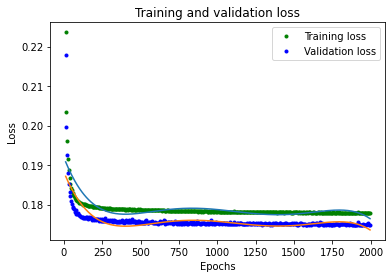

In [102]:
show_history(history_1)

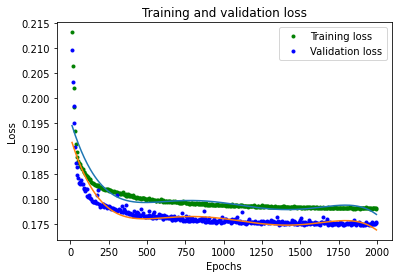

In [103]:
show_history(history_2)

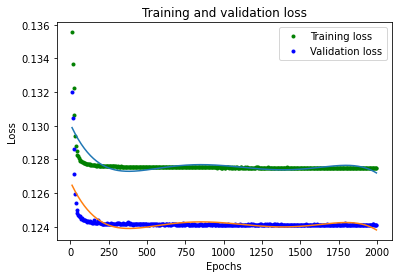

In [104]:
show_history(history_3)

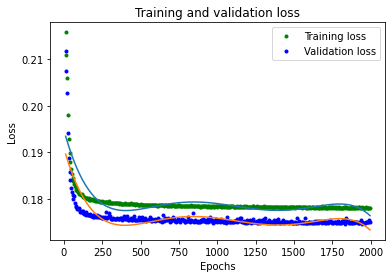

In [105]:
show_history(history_4)

## Тестирование обученной сети

Применим новые данные, на которых сеть не обучалась. 

При этом не забудем про подготовку входных и выходных параметров. 

In [ ]:
# df1 = pd.read_csv('mosfet_val_3.csv') # проверка на работоспособность

In [ ]:
# xval, yval = data.transform(df1) # проверка на работоспособность

In [ ]:
# def show_val(xval, yval, df):
#   """Функция графиков валидационных кривых"""
#   vg1=df["Vds"] #change this index to vgs if you are going to plot Id-Vg
#   vg=np.ravel(vg1)
#   vg=vg.reshape(-1,1)
#   plt.plot(vg, 10**(-1/yval), 'ro', label='Actual')

#   plt.title('Actual and Predicted Value')
#   plt.xlabel('Drain Voltage (Vds)')
#   plt.ylabel('Drain Current(Id)')
#   plt.legend()

In [ ]:
# def show_pred(model, xval, df, name='', begin=0):
#   """Функция графиков предскасказаний сети"""
#   # Predict the new dataset
#   y_pred = model.predict(xval)
#   #plot the result
#   vg1=df["Vds"] #change this index to vgs if you are going to plot Id-Vg
#   vg=np.ravel(vg1)
#   vg=vg.reshape(-1,1)

#   plt.plot(vg[begin:], 10**(-1/y_pred)[begin:], label='Predicted ' + name)

Вспомним что область обучения лежала в пределах 0 до 3 В для напржений

In [106]:
data = ProcessDataLogNorm(df)

2/2 [==============================] - 0s 2ms/step
MAX loss:  1.0258381026603234e-15 mae:  3.202870747720431e-08
MEAN loss:  1.0177273432325224e-15 mae:  3.1901612648664136e-08
MAX value:  1.9700485379062725e-19 mae: 4.438522882566083e-10
MEAN value:  3.061276863014669e-20 mae: 1.2712881021117055e-10
2/2 [==============================] - 0s 1ms/step
MAX loss:  1.0258781889358475e-15 mae:  3.202933325774746e-08
MEAN loss:  1.0177502738628515e-15 mae:  3.1901972022704805e-08
MAX value:  1.9700485379062725e-19 mae: 4.438522882566083e-10
MEAN value:  3.061276863014669e-20 mae: 1.2712881021117055e-10
2/2 [==============================] - 0s 997us/step
MAX loss:  1.0258042810131323e-15 mae:  3.202817948327898e-08
MEAN loss:  1.0177424475585224e-15 mae:  3.1901849880625114e-08
MAX value:  1.9700485379062725e-19 mae: 4.438522882566083e-10
MEAN value:  3.061276863014669e-20 mae: 1.2712881021117055e-10


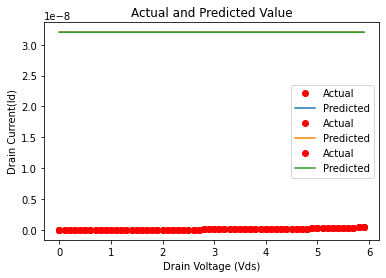

In [113]:
plot_predict('mosfet_val_1.csv', model_1, process_data=data.transform, reprocess_data=data.retransform_y)
plot_predict('mosfet_val_1.csv', model_2, process_data=data.transform, reprocess_data=data.retransform_y)
plot_predict('mosfet_val_1.csv', model_3, process_data=data.transform, reprocess_data=data.retransform_y)
# plot_predict('mosfet_val_1.csv', model_4, process_data=data.transform, reprocess_data=data.retransform_y)

2/2 [==============================] - 0s 2ms/step
max loss:  3.0888051447978614e-14
mean post-prox loss:  tf.Tensor(7.022379483403631e-15, shape=(), dtype=float64)
max mae:  1.7574996855754658e-07
mean post-prox mae:  tf.Tensor(6.208579992508014e-08, shape=(), dtype=float64)
max MAPE:  44.473993054370744
mean post-prox MAPE:  tf.Tensor(5.459605404628233, shape=(), dtype=float64)
2/2 [==============================] - 0s 997us/step
max loss:  5.09239961701257e-12
mean post-prox loss:  tf.Tensor(7.113546171700139e-13, shape=(), dtype=float64)
max mae:  2.256634577642683e-06
mean post-prox mae:  tf.Tensor(5.220739777656965e-07, shape=(), dtype=float64)
max MAPE:  54.43793057514269
mean post-prox MAPE:  tf.Tensor(20.783206607647752, shape=(), dtype=float64)
2/2 [==============================] - 0s 997us/step
max loss:  1.943978683731096e-12
mean post-prox loss:  tf.Tensor(3.1649752116107815e-13, shape=(), dtype=float64)
max mae:  1.3942663603957087e-06
mean post-prox mae:  tf.Tensor(4.00

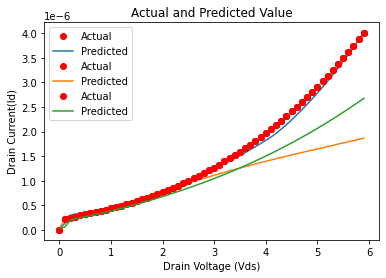

In [163]:
plot_predict('mosfet_val_2.csv', model_1, process_data=data.transform, reprocess_data=data.retransform_y)
plot_predict('mosfet_val_2.csv', model_2, process_data=data.transform, reprocess_data=data.retransform_y)
# plot_predict('mosfet_val_2.csv', model_3, process_data=data.transform, reprocess_data=data.retransform_y)
plot_predict('mosfet_val_2.csv', model_4, process_data=data.transform, reprocess_data=data.retransform_y)

2/2 [==============================] - 0s 2ms/step
max loss:  1.4420025261432763e-09
mean post-prox loss:  tf.Tensor(3.540636724774693e-10, shape=(), dtype=float64)
max mae:  3.797370835385025e-05
mean post-prox mae:  tf.Tensor(1.3918650844039303e-05, shape=(), dtype=float64)
max MAPE:  32.02925503458834
mean post-prox MAPE:  tf.Tensor(7.8823999157173095, shape=(), dtype=float64)
2/2 [==============================] - 0s 2ms/step
max loss:  4.478953149990202e-10
mean post-prox loss:  tf.Tensor(3.233994157502329e-10, shape=(), dtype=float64)
max mae:  2.116353739333338e-05
mean post-prox mae:  tf.Tensor(1.7150788999725485e-05, shape=(), dtype=float64)
max MAPE:  33.61251750537597
mean post-prox MAPE:  tf.Tensor(10.063710773179114, shape=(), dtype=float64)
2/2 [==============================] - 0s 997us/step
max loss:  2.194740926020943e-10
mean post-prox loss:  tf.Tensor(5.639073016124582e-11, shape=(), dtype=float64)
max mae:  1.4814658031898486e-05
mean post-prox mae:  tf.Tensor(6.235

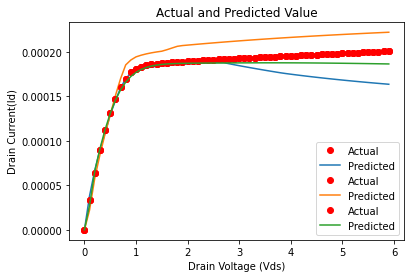

In [164]:
plot_predict('mosfet_val_3.csv', model_1, process_data=data.transform, reprocess_data=data.retransform_y)
plot_predict('mosfet_val_3.csv', model_2, process_data=data.transform, reprocess_data=data.retransform_y)
# plot_predict('mosfet_val_3.csv', model_3, process_data=data.transform, reprocess_data=data.retransform_y)
plot_predict('mosfet_val_3.csv', model_4, process_data=data.transform, reprocess_data=data.retransform_y)

2/2 [==============================] - 0s 3ms/step
MAX loss:  1.036837219737953e-07 mae:  0.00032199956828200143
MEAN loss:  5.464782119172462e-08 mae:  0.0001995160147317006
MAX value:  4.851506684313049e-07 mae: 0.0006965275790888002
MEAN value:  3.1843927403919354e-07 mae: 0.0005260242162125752
2/2 [==============================] - 0s 1ms/step
MAX loss:  1.036837219737953e-07 mae:  0.00032199956828200143
MEAN loss:  5.5001358942129706e-08 mae:  0.00020359953184155617
MAX value:  4.851506684313049e-07 mae: 0.0006965275790888002
MEAN value:  3.1843927403919354e-07 mae: 0.0005260242162125752
2/2 [==============================] - 0s 1ms/step
MAX loss:  1.036845839227523e-07 mae:  0.0003220009067110717
MEAN loss:  5.478433602975697e-08 mae:  0.00020215671025710204
MAX value:  4.851506684313049e-07 mae: 0.0006965275790888002
MEAN value:  3.1843927403919354e-07 mae: 0.0005260242162125752
2/2 [==============================] - 0s 2ms/step
MAX loss:  1.0387051778676752e-07 mae:  0.00032228

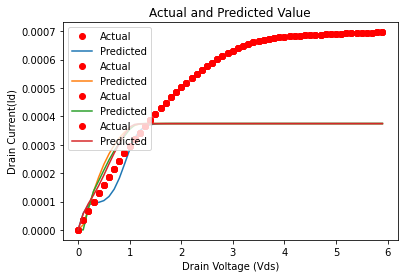

In [117]:
plot_predict('mosfet_val_4.csv', model_1, process_data=data.transform, reprocess_data=data.retransform_y)
plot_predict('mosfet_val_4.csv', model_2, process_data=data.transform, reprocess_data=data.retransform_y)
plot_predict('mosfet_val_4.csv', model_3, process_data=data.transform, reprocess_data=data.retransform_y)
plot_predict('mosfet_val_4.csv', model_4, process_data=data.transform, reprocess_data=data.retransform_y)

3/3 [==============================] - 0s 998us/step
MAX loss:  2.339769704926573e-09 mae:  4.837116604886193e-05
MEAN loss:  1.6200214162233312e-09 mae:  3.961529768857839e-05
MAX value:  4.427380185363794e-08 mae: 0.00021041340701970001
MEAN value:  3.783871433050166e-08 mae: 0.00019059467976069889
3/3 [==============================] - 0s 1ms/step
MAX loss:  1.5110292871159352e-08 mae:  0.00012292393123862965
MEAN loss:  1.1773235914187687e-08 mae:  0.0001061134197625287
MAX value:  4.427380185363794e-08 mae: 0.00021041340701970001
MEAN value:  3.783871433050166e-08 mae: 0.00019059467976069889
3/3 [==============================] - 0s 998us/step
MAX loss:  7.742435931842105e-09 mae:  8.79911128003397e-05
MEAN loss:  5.308483931029352e-09 mae:  6.888922594420688e-05
MAX value:  4.427380185363794e-08 mae: 0.00021041340701970001
MEAN value:  3.783871433050166e-08 mae: 0.00019059467976069889
3/3 [==============================] - 0s 999us/step
MAX loss:  1.5450188263455155e-09 mae:  3.9

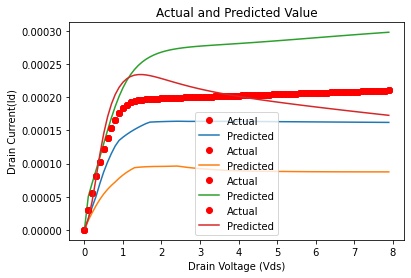

In [118]:
plot_predict('mosfet_val_5.csv', model_1, process_data=data.transform, reprocess_data=data.retransform_y)
plot_predict('mosfet_val_5.csv', model_2, process_data=data.transform, reprocess_data=data.retransform_y)
plot_predict('mosfet_val_5.csv', model_3, process_data=data.transform, reprocess_data=data.retransform_y)
plot_predict('mosfet_val_5.csv', model_4, process_data=data.transform, reprocess_data=data.retransform_y)

19/19 [==============================] - 0s 1ms/step
max loss:  1.4420025261280903e-09
mean post-prox loss:  tf.Tensor(3.4861507399457604e-10, shape=(), dtype=float64)
max mae:  3.7973708353650296e-05
mean post-prox mae:  tf.Tensor(1.3878235597270784e-05, shape=(), dtype=float64)
max MAPE:  98.62015886791538
mean post-prox MAPE:  tf.Tensor(7.811213718665703, shape=(), dtype=float64)
19/19 [==============================] - 0s 721us/step
max loss:  4.478953149990202e-10
mean post-prox loss:  tf.Tensor(3.2569582443637137e-10, shape=(), dtype=float64)
max mae:  2.116353739333338e-05
mean post-prox mae:  tf.Tensor(1.730108689763718e-05, shape=(), dtype=float64)
max MAPE:  99.54086969718536
mean post-prox MAPE:  tf.Tensor(10.478153019413524, shape=(), dtype=float64)
19/19 [==============================] - 0s 713us/step
max loss:  2.194740925961698e-10
mean post-prox loss:  tf.Tensor(5.673737866804688e-11, shape=(), dtype=float64)
max mae:  1.4814658031698532e-05
mean post-prox mae:  tf.Ten

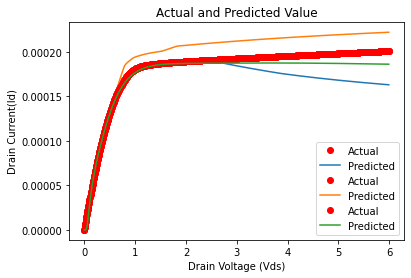

In [165]:
plot_predict('mosfet_val_6.csv', model_1, process_data=data.transform, reprocess_data=data.retransform_y)
plot_predict('mosfet_val_6.csv', model_2, process_data=data.transform, reprocess_data=data.retransform_y)
# plot_predict('mosfet_val_6.csv', model_3, process_data=data.transform, reprocess_data=data.retransform_y)
plot_predict('mosfet_val_6.csv', model_4, process_data=data.transform, reprocess_data=data.retransform_y)

Проверим теперь производные

In [120]:
def show_pred_grad(df, model, pr='Vds', name='', begin=3):
  """Функция графика производной предсказания сети"""
  # Predict the new dataset
  xval, yval = data.transform(df1)
  y_pred = model.predict(xval)
  y_pred = data.retransform_y(y_pred)
  y_pred = y_pred.reshape(-1)

  vg1=df[pr] #change this index to vgs if you are going to plot Id-Vg

  plt.plot(vg1[begin:], np.gradient(y_pred)[begin:], label='Predicted ' + name)

2/2 [==============================] - 0s 2ms/step


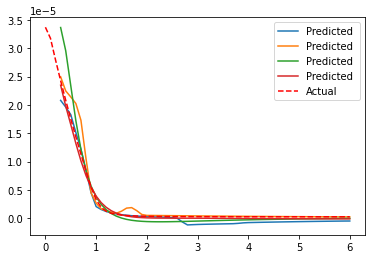

In [122]:
df1 = pd.read_csv('mosfet_val_3.csv')
show_pred_grad(df1, model_1)
show_pred_grad(df1, model_2)
show_pred_grad(df1, model_3)
show_pred_grad(df1, model_4)
plt.plot(df1['Vds'], np.gradient(df1['Id']), 'r--', label='Actual')
plt.legend()

2/2 [==============================] - 0s 2ms/step


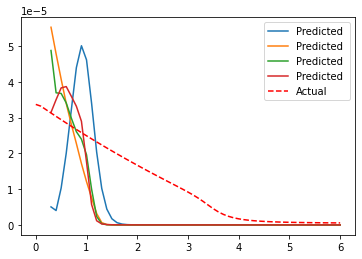

In [123]:
df1 = pd.read_csv('mosfet_val_4.csv')
show_pred_grad(df1, model_1)
show_pred_grad(df1, model_2)
show_pred_grad(df1, model_3)
show_pred_grad(df1, model_4)
plt.plot(df1['Vds'], np.gradient(df1['Id']), 'r--', label='Actual')
plt.legend()

19/19 [==============================] - 0s 997us/step


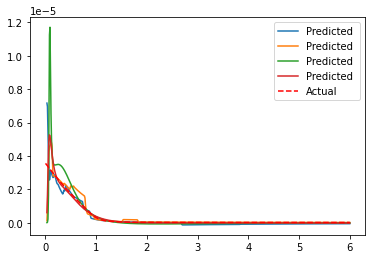

In [126]:
df1 = pd.read_csv('mosfet_val_6.csv')
show_pred_grad(df1, model_1)
show_pred_grad(df1, model_2)
show_pred_grad(df1, model_3)
show_pred_grad(df1, model_4)
plt.plot(df1['Vds'], np.gradient(df1['Id']), 'r--', label='Actual')
plt.legend()

Теперь тут производная по V_gs

16/16 [==============================] - 0s 1ms/step


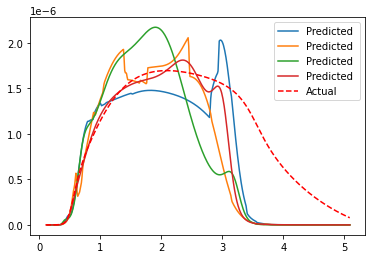

In [128]:
df1 = pd.read_csv('mosfet_val_9.csv')
show_pred_grad(df1, model_1, pr='Vgs')
show_pred_grad(df1, model_2, pr='Vgs')
show_pred_grad(df1, model_3, pr='Vgs')
show_pred_grad(df1, model_4, pr='Vgs')
plt.plot(df1['Vgs'], np.gradient(df1['Id']), 'r--', label='Actual')
plt.legend()

Значние ранее

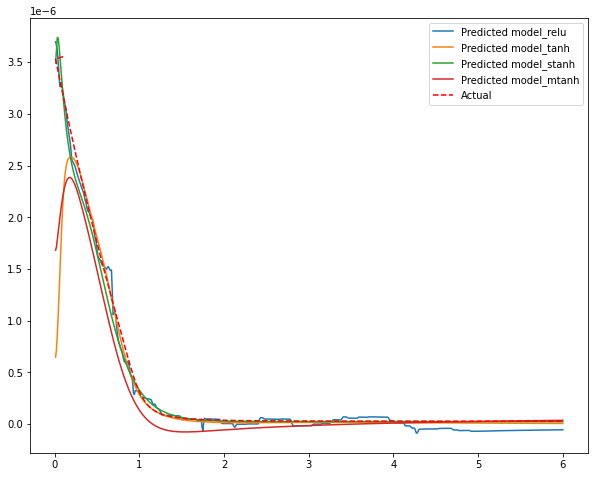

In [ ]:
df1 = pd.read_csv('mosfet_val_6.csv')
# xval, yval, df_ = process_data(df1)

fig, ax = plt.subplots(figsize=(10, 8))

show_pred_grad(model_relu, xval, df1, 'Vds',  'model_relu')
show_pred_grad(model_tanh, xval, df1, 'Vds', 'model_tanh')
# show_pred_grad(model_srelu, xval, df1, 'Vds', 'model_srelu')
show_pred_grad(model_stanh, xval, df1, 'Vds', 'model_stanh')
show_pred_grad(model_mtanh, xval, df1, 'Vds', 'model_mtanh')
# show_val_grad(xval, yval, df1)
plt.plot(df1['Vds'], np.gradient(df1['Id']), 'r--', label='Actual')
plt.legend()

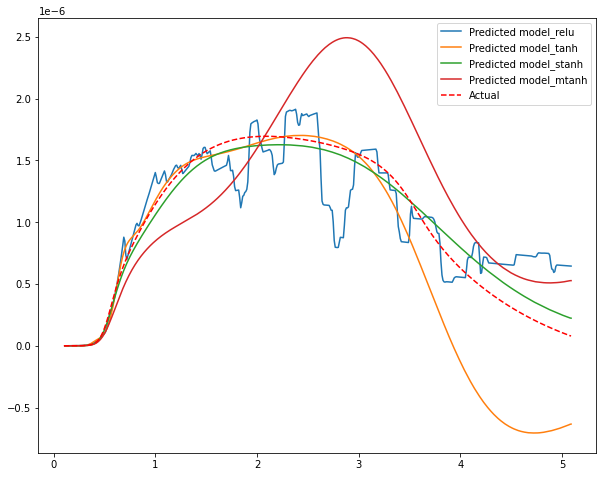

In [ ]:
df1 = pd.read_csv('mosfet_val_9.csv')
xval, yval, df_ = process_data(df1)

fig, ax = plt.subplots(figsize=(10, 8))

show_pred_grad(model_relu, xval, df1, 'Vgs',  'model_relu')
show_pred_grad(model_tanh, xval, df1, 'Vgs', 'model_tanh')
# show_pred_grad(model_srelu, xval, df1, 'Vgs', 'model_srelu')
show_pred_grad(model_stanh, xval, df1, 'Vgs', 'model_stanh')
show_pred_grad(model_mtanh, xval, df1, 'Vgs', 'model_mtanh')
# show_val_grad(xval, yval, df1)
plt.plot(df1['Vgs'], np.gradient(df1['Id']), 'r--', label='Actual')
plt.legend()

Посчитаем MSE для валиадционных данных внутри области обчения

(аккуратнее с переполнением)

In [129]:
df_val = pd.read_csv('data_val_in.csv')
# df_val = pd.read_csv('mosfet_simple.csv')

In [130]:
df_val.shape

(556875, 6)

In [131]:
Xval, yval = data.transform(df_val)

In [143]:
def print_loss(yval, y_pred):
    loss = keras.losses.MSE(yval, y_pred)
    print('max loss: ', np.max(loss))
    loss_mean = tf.reduce_mean(loss) # Рассчитать среднеквадратичную ошибку партии
    print('mean post-prox loss: ', loss_mean)
    
    loss = keras.losses.MAE(yval, y_pred)
    print('max mae: ', np.max(loss))
    loss_mean = tf.reduce_mean(loss) # Рассчитать среднеквадратичную ошибку партии
    print('mean post-prox mae: ', loss_mean)
    
    loss = keras.losses.MAPE(yval, y_pred)
    print('max MAPE: ', np.max(loss))
    loss_mean = tf.reduce_mean(loss) # Рассчитать среднеквадратичную ошибку партии
    print('mean post-prox MAPE: ', loss_mean)

In [144]:
y_pred = model_1.predict(Xval)
y_1 = data.retransform_y(yval)
y_2 = data.retransform_y(y_pred)
print_loss(y_1, y_2)

17403/17403 [==============================] - 13s 745us/step
max loss:  5.752635239747805e-07
mean post-prox loss:  tf.Tensor(3.880085814679859e-09, shape=(), dtype=float64)
max mae:  0.0007584612870640007
mean post-prox mae:  tf.Tensor(1.9791428637417617e-05, shape=(), dtype=float64)
max MAPE:  235.56374621186555
mean post-prox MAPE:  tf.Tensor(14.931268934315446, shape=(), dtype=float64)


max loss:  5.752680921360905e-07
mean post-prox loss:  tf.Tensor(3.937789025993993e-09, shape=(), dtype=float64)

In [145]:
y_pred = model_2.predict(Xval)
y_1 = data.retransform_y(yval)
y_2 = data.retransform_y(y_pred)
print_loss(y_1, y_2)

17403/17403 [==============================] - 12s 707us/step
max loss:  5.752635239747805e-07
mean post-prox loss:  tf.Tensor(4.015847737691808e-09, shape=(), dtype=float64)
max mae:  0.0007584612870640007
mean post-prox mae:  tf.Tensor(2.2717562347535748e-05, shape=(), dtype=float64)
max MAPE:  176.28869394479656
mean post-prox MAPE:  tf.Tensor(18.106121555483874, shape=(), dtype=float64)


max loss:  5.75265481759336e-07
mean post-prox loss:  tf.Tensor(4.968530552609526e-09, shape=(), dtype=float64)

In [146]:
y_pred = model_3.predict(Xval)
y_1 = data.retransform_y(yval)
y_2 = data.retransform_y(y_pred)
print_loss(y_1, y_2)

17403/17403 [==============================] - 13s 733us/step
max loss:  5.752635239747805e-07
mean post-prox loss:  tf.Tensor(7.660616459012372e-09, shape=(), dtype=float64)
max mae:  0.0007584612870640007
mean post-prox mae:  tf.Tensor(4.149299740689457e-05, shape=(), dtype=float64)
max MAPE:  27620.084103527155
mean post-prox MAPE:  tf.Tensor(40.32881960578725, shape=(), dtype=float64)


max loss:  5.7526424908037e-07
mean post-prox loss:  tf.Tensor(3.7913474923305375e-09, shape=(), dtype=float64)

In [147]:
y_pred = model_4.predict(Xval)
y_1 = data.retransform_y(yval)
y_2 = data.retransform_y(y_pred)
print_loss(y_1, y_2)

17403/17403 [==============================] - 11s 637us/step
max loss:  5.756728813534897e-07
mean post-prox loss:  tf.Tensor(3.7992114423519205e-09, shape=(), dtype=float64)
max mae:  0.0007587310995033021
mean post-prox mae:  tf.Tensor(1.711034080173867e-05, shape=(), dtype=float64)
max MAPE:  152.37561439180445
mean post-prox MAPE:  tf.Tensor(12.39514899410145, shape=(), dtype=float64)


max loss:  5.752635239747805e-07
mean post-prox loss:  tf.Tensor(3.777850537832754e-09, shape=(), dtype=float64)

Посчитаем MSE на данных, которые находятся вне области обучения



In [148]:
df_val_out = pd.read_csv('data_val_out.csv')

In [149]:
df_val_out.describe()

,Vds,Vgs,L,W,T,Id
count,302580.000000,302580.000000,3.025800e+05,3.025800e+05,302580.000000,3.025800e+05
mean,3.000000,3.000000,9.500000e-07,9.500000e-07,50.000000,4.459659e-04
std,1.774827,1.774827,5.123484e-07,5.123484e-07,35.355397,5.479167e-04
min,0.000000,0.000000,2.000000e-07,2.000000e-07,0.000000,-1.046136e-18
25%,1.500000,1.500000,5.000000e-07,5.000000e-07,25.000000,5.231339e-05
50%,3.000000,3.000000,9.500000e-07,9.500000e-07,50.000000,2.471728e-04
75%,4.500000,4.500000,1.400000e-06,1.400000e-06,75.000000,6.370231e-04
max,6.000000,6.000000,1.700000e-06,1.700000e-06,100.000000,3.978165e-03


Посмотрим на область напряжений

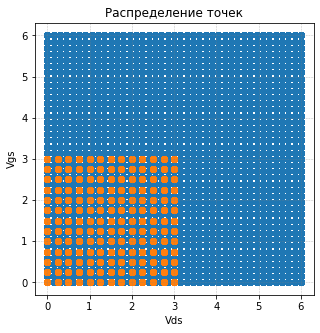

In [150]:
x = df[df['T'] == df.iloc[0]['T']]['Vds']
y = df[df['T'] == df.iloc[0]['T']]['Vgs']

x_val = df_val_out[df_val_out['T'] == df_val_out.iloc[0]['T']]['Vds']
y_val = df_val_out[df_val_out['T'] == df_val_out.iloc[0]['T']]['Vgs']

fig, ax = plt.subplots(figsize=(5, 5))
ax.set(xlabel='Vds', ylabel='Vgs', title='Распределение точек')
ax.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5)

# plt.scatter(x, y)
plt.scatter(x_val, y_val)
plt.scatter(x, y)
plt.show()

Посмотрим на область технических параметров

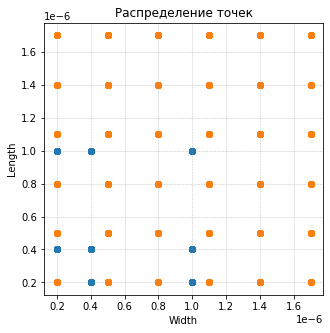

In [151]:
x = df[df['T'] == df.iloc[0]['T']]['W']
y = df[df['T'] == df.iloc[0]['T']]['L']

x_val = df_val_out[df_val_out['T'] == df_val_out.iloc[0]['T']]['W']
y_val = df_val_out[df_val_out['T'] == df_val_out.iloc[0]['T']]['L']

fig, ax = plt.subplots(figsize=(5, 5))
ax.set(xlabel='Width', ylabel='Length', title='Распределение точек')
ax.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5)

plt.scatter(x, y)
plt.scatter(x_val, y_val)
plt.show()

Вновь посчитаем сред квадр ошибку, но только теперь для внешней области

In [152]:
Xval_out, yval_out = data.transform(df_val_out)

In [153]:
y_pred = model_1.predict(Xval_out)
y_1 = data.retransform_y(yval_out)
y_2 = data.retransform_y(y_pred)
print_loss(y_1, y_2)

9456/9456 [==============================] - 8s 806us/step
max loss:  1.2986200216894509e-05
mean post-prox loss:  tf.Tensor(2.588269134057263e-07, shape=(), dtype=float64)
max mae:  0.003603637081740406
mean post-prox mae:  tf.Tensor(0.00024215955174951322, shape=(), dtype=float64)
max MAPE:  2759.6462931689066
mean post-prox MAPE:  tf.Tensor(33.79666974904673, shape=(), dtype=float64)


max loss:  1.2986552641617138e-05
mean post-prox loss:  tf.Tensor(2.9088336408776717e-07, shape=(), dtype=float64)

In [155]:
y_pred = model_2.predict(Xval_out)
y_1 = data.retransform_y(yval_out)
y_2 = data.retransform_y(y_pred)
print_loss(y_1, y_2)

9456/9456 [==============================] - 7s 785us/step
max loss:  1.2986200216894509e-05
mean post-prox loss:  tf.Tensor(2.6349804714592367e-07, shape=(), dtype=float64)
max mae:  0.003603637081740406
mean post-prox mae:  tf.Tensor(0.00025779133328593205, shape=(), dtype=float64)
max MAPE:  642.8217731689629
mean post-prox MAPE:  tf.Tensor(39.25344182657762, shape=(), dtype=float64)


max loss:  1.2996641538230282e-05
mean post-prox loss:  tf.Tensor(2.83370642011605e-07, shape=(), dtype=float64)

In [156]:
y_pred = model_3.predict(Xval_out)
y_1 = data.retransform_y(yval_out)
y_2 = data.retransform_y(y_pred)
print_loss(y_1, y_2)

9456/9456 [==============================] - 7s 736us/step
max loss:  1.298622674451559e-05
mean post-prox loss:  tf.Tensor(2.5974163538756736e-07, shape=(), dtype=float64)
max mae:  0.003603640762411757
mean post-prox mae:  tf.Tensor(0.00024809832619150646, shape=(), dtype=float64)
max MAPE:  42969.612481059514
mean post-prox MAPE:  tf.Tensor(48.93108791739301, shape=(), dtype=float64)


max loss:  1.2986205040110801e-05
mean post-prox loss:  tf.Tensor(2.579063159860596e-07, shape=(), dtype=float64)

In [157]:
y_pred = model_4.predict(Xval_out)
y_1 = data.retransform_y(yval_out)
y_2 = data.retransform_y(y_pred)
print_loss(y_1, y_2)

9456/9456 [==============================] - 6s 662us/step
max loss:  1.2988403505403606e-05
mean post-prox loss:  tf.Tensor(2.580037361596458e-07, shape=(), dtype=float64)
max mae:  0.0036039427722153977
mean post-prox mae:  tf.Tensor(0.0002389938888377062, shape=(), dtype=float64)
max MAPE:  570.0740315046465
mean post-prox MAPE:  tf.Tensor(32.53399616514074, shape=(), dtype=float64)


max loss:  1.2986200216894509e-05
mean post-prox loss:  tf.Tensor(2.579094953826248e-07, shape=(), dtype=float64)

In [158]:
df_sim = pd.read_csv('../dataset_csv/mosfet_simple.csv')
# df_sim.head()

In [159]:
df_noise = pd.read_csv('../dataset_csv/mosfet_noise.csv')
# df_noise.head()

In [160]:
df = pd.read_csv('../dataset_csv/mosfet_noise_5.csv')
data_lognorm = ProcessDataLogNorm(df)

In [161]:
y_pred = df_noise['Id']
yval = df_sim['Id']
# print(y_pred, yval)
y_1 = data_lognorm.retransform_y(yval)
y_2 = data_lognorm.retransform_y(y_pred)
# print('Y1: ', y_1.to_list(), '\n Y2: ', y_2)
# print_loss(y_1.to_list(), y_2.to_list())
print_loss(y_1, y_2)

max loss:  1.0681201459770806e-18
mean post-prox loss:  tf.Tensor(1.0681201459770806e-18, shape=(), dtype=float64)
max mae:  5.199743656865457e-10
mean post-prox mae:  tf.Tensor(5.199743656865457e-10, shape=(), dtype=float64)
max MAPE:  0.0026192207709672274
mean post-prox MAPE:  tf.Tensor(0.0026192207709672274, shape=(), dtype=float64)


In [72]:
def print_loss(yval, y_pred):
    loss = keras.losses.MSE(yval, y_pred)
    print('loss --- ', loss)
    print('max loss: ', np.max(loss))
    loss_mean = tf.reduce_mean(loss) # Рассчитать среднеквадратичную ошибку партии
    print('mean post-prox loss: ', loss_mean)